In [1]:
import os
from typing import Optional, List, Tuple
from ultralytics import YOLO
from PIL import Image

def is_image_file(filename: str) -> bool:
    """
    Check if the file is a valid image file based on its extension.

    Args:
        filename (str): The name of the file to check.

    Returns:
        bool: True if the file has a valid image extension, False otherwise.
    """
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def run_obb_yolo_inference(
    input_dir: str,
    output_dir: str,
    model_path: str,
    imgsz: int = 640,
    conf: float = 0.50,
    save_all_obb: bool = True,
    normalize: bool = True,
    include_class_id: bool = True
) -> None:
    """
    Run YOLO inference on images in a directory and save results as text files.

    Args:
        input_dir (str): Path to the input directory containing images.
        output_dir (str): Path to the output directory where images and labels will be saved.
        model_path (str): Path to the YOLO model weights file.
        imgsz (int, optional): Image size for inference. Defaults to 640.
        conf (float, optional): Confidence threshold for predictions. Defaults to 0.50.
        save_all_obb (bool, optional): If True, save all detected oriented bounding boxes (OBBs).
            If False, save only the first OBB. Defaults to True.
        normalize (bool, optional): If True, save normalized coordinates. If False, save absolute coordinates.
            Defaults to True.
        include_class_id (bool, optional): If True, include class ID in the output files. Defaults to True.

    Returns:
        None
    """
    # Load the YOLO model
    model = YOLO(model_path)

    # Create output directories for labels and images
    labels_dir = os.path.join(output_dir, 'labels')
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)

    # Get list of image files in the input directory
    image_files = [f for f in sorted(os.listdir(input_dir)) if is_image_file(f)]

    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)

        # Skip if the file is not valid
        if not os.path.isfile(image_path):
            continue

        try:
            # Run YOLO inference
            results = model.predict(source=image_path, imgsz=imgsz, conf=conf, save=False)
        except FileNotFoundError:
            print(f"File not found or invalid image: {image_path}")
            continue

        # Process each result for the current image
        for result in results:
            # Save the predicted image
            output_image_path = os.path.join(images_dir, image_file)
            result_image = result.plot()
            im_rgb = Image.fromarray(result_image[..., ::-1])  # Convert BGR to RGB
            im_rgb.save(output_image_path)
            print(f"Saved predicted image for {image_file} in {images_dir}")

            # Prepare the label file path
            base_filename = os.path.splitext(image_file)[0]
            output_label_file_path = os.path.join(labels_dir, f"{base_filename}.txt")

            # Write detected bounding boxes to the label file
            with open(output_label_file_path, 'w') as label_file:
                if result.obb is not None and len(result.obb) > 0:
                    obbs = result.obb if save_all_obb else [result.obb[0]]  # Save all or first OBB

                    for obb in obbs:
                        # Get class ID and coordinates
                        class_id = int(obb.cls.item()) if include_class_id else None
                        coordinates = (
                            obb.xyxyn.cpu().numpy().flatten() if normalize
                            else obb.xyxyxyxy.cpu().numpy().flatten()
                        )

                        # Write to file
                        if include_class_id:
                            label_file.write(f"{class_id} {' '.join(map(str, coordinates))}\n")
                        else:
                            label_file.write(f"{' '.join(map(str, coordinates))}\n")

            print(f"Processed and saved labels for {image_file} in {labels_dir}")

    print("Inference complete. Results saved.")



In [27]:
# FIRST STEP
image_directory = "/Users/jocareher/Documents/natural_babies" # Path to your input images directory
output_directory = "preds_nats"  # Path to your output directory for labels

run_obb_yolo_inference(image_directory, output_directory, model_path="/Users/jocareher/Library/CloudStorage/OneDrive-Personal/Educación/PhD_UPF_2023/models_weights/obbabyface_weights.pt")






image 1/1 /Users/jocareher/Documents/natural_babies/extra_faces_05.jpg: 640x448 109.1ms
Speed: 0.9ms preprocess, 109.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)
Saved predicted image for extra_faces_05.jpg in preds_nats/images


AttributeError: 'OBB' object has no attribute 'xyxyn'. See valid attributes below.

    A class for storing and manipulating Oriented Bounding Boxes (OBB).

    This class provides functionality to handle oriented bounding boxes, including conversion between
    different formats, normalization, and access to various properties of the boxes.

    Attributes:
        data (torch.Tensor): The raw OBB tensor containing box coordinates and associated data.
        orig_shape (tuple): Original image size as (height, width).
        is_track (bool): Indicates whether tracking IDs are included in the box data.
        xywhr (torch.Tensor | numpy.ndarray): Boxes in [x_center, y_center, width, height, rotation] format.
        conf (torch.Tensor | numpy.ndarray): Confidence scores for each box.
        cls (torch.Tensor | numpy.ndarray): Class labels for each box.
        id (torch.Tensor | numpy.ndarray): Tracking IDs for each box, if available.
        xyxyxyxy (torch.Tensor | numpy.ndarray): Boxes in 8-point [x1, y1, x2, y2, x3, y3, x4, y4] format.
        xyxyxyxyn (torch.Tensor | numpy.ndarray): Normalized 8-point coordinates relative to orig_shape.
        xyxy (torch.Tensor | numpy.ndarray): Axis-aligned bounding boxes in [x1, y1, x2, y2] format.

    Methods:
        cpu(): Returns a copy of the OBB object with all tensors on CPU memory.
        numpy(): Returns a copy of the OBB object with all tensors as numpy arrays.
        cuda(): Returns a copy of the OBB object with all tensors on GPU memory.
        to(*args, **kwargs): Returns a copy of the OBB object with tensors on specified device and dtype.

    Examples:
        >>> boxes = torch.tensor([[100, 50, 150, 100, 30, 0.9, 0]])  # xywhr, conf, cls
        >>> obb = OBB(boxes, orig_shape=(480, 640))
        >>> print(obb.xyxyxyxy)
        >>> print(obb.conf)
        >>> print(obb.cls)
    

In [9]:
def handle_empty_txt_files(directory: str, delete: bool = False) -> List[str]:
    """
    List or delete empty .txt files in a directory. Optionally, delete corresponding image files.

    Args:
        directory (str): Path to the directory containing .txt files and an associated 'images' folder.
        delete (bool, optional): If True, delete empty .txt files and corresponding images. Defaults to False.

    Returns:
        List[str]: List of empty .txt file paths found in the directory.
    """
    empty_files = []

    # Define directories
    labels_dir = os.path.join(directory, 'labels')
    images_dir = os.path.join(directory, 'images')

    # Check if 'labels' and 'images' directories exist
    if not os.path.exists(labels_dir):
        print(f"Labels directory '{labels_dir}' not found.")
        return []

    if not os.path.exists(images_dir):
        print(f"Images directory '{images_dir}' not found.")

    # Traverse through all .txt files in the 'labels' directory
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_file_path = os.path.join(labels_dir, label_file)

            # Check if the label file is empty
            if os.path.getsize(label_file_path) == 0:
                empty_files.append(label_file_path)

                if delete:
                    # Delete the empty label file
                    os.remove(label_file_path)
                    print(f"Deleted empty label file: {label_file_path}")

                    # Construct the corresponding image file path
                    base_name = os.path.splitext(label_file)[0]
                    image_file_path = os.path.join(images_dir, f"{base_name}.jpg")  # Assuming images are .jpg

                    # Delete the corresponding image file if it exists
                    if os.path.exists(image_file_path):
                        os.remove(image_file_path)
                        print(f"Deleted corresponding image file: {image_file_path}")

    if not delete:
        print(f"Found {len(empty_files)} empty .txt files.")

    return empty_files

In [39]:
root_directory = "/Users/jocareher/Downloads/preds"
handle_empty_txt_files(root_directory)

In [ ]:
def remove_images_without_labels(root_directory):
    """
    Removes images from the 'images' folder if there is no corresponding .txt file
    with the same base name in the 'labels' folder.

    Args:
        root_directory (str): Path to the root directory containing 'images' and 'labels' subfolders.
    """
    labels_dir = os.path.join(root_directory, 'labels')
    images_dir = os.path.join(root_directory, 'images')

    # Check if 'labels' and 'images' directories exist
    if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
        print("Error: 'labels' or 'images' directory not found in the specified root directory.")
        return

    # Get the base names of all label files (without extension)
    label_basenames = {os.path.splitext(label_file)[0] for label_file in os.listdir(labels_dir) if label_file.endswith('.txt')}

    # Traverse through all image files in the 'images' directory
    for image_file in os.listdir(images_dir):
        # Check if file is an image based on its extension
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            image_basename = os.path.splitext(image_file)[0]
            
            # If the image base name is not in the label basenames, delete the image
            if image_basename not in label_basenames:
                image_file_path = os.path.join(images_dir, image_file)
                os.remove(image_file_path)
                print(f"Deleted image without corresponding label: {image_file_path}")

In [41]:
root_directory = "/Users/jocareher/Downloads/preds"
remove_images_without_labels(root_directory)

Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00386_left.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00786_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_01899_quarter_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_01241_left.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00309_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00121_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00009_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00385_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/pred

In [43]:
def sync_directories(dir_a, dir_b):
    """
    Delete files in dir_a that are not present in dir_b.

    Args:
        dir_a (str): Path to the directory where files will be deleted if not present in dir_b.
        dir_b (str): Path to the reference directory to check for file presence.
    """
    # Get a set of filenames (without extension) in dir_b
    files_in_b = {os.path.splitext(f)[0] for f in os.listdir(dir_b) if f.endswith('.txt')}

    # Iterate over files in dir_a and delete those not in dir_b
    for file in os.listdir(dir_a):
        if file.endswith('.txt'):
            file_base = os.path.splitext(file)[0]
            if file_base not in files_in_b:
                file_path = os.path.join(dir_a, file)
                os.remove(file_path)
                print(f"Deleted {file_path}")

# Usage example:
sync_directories("/Users/jocareher/Documents/lmks_dataset/labels_copy", "/Users/jocareher/Downloads/preds/labels")

Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00385_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00121_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00009_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01165_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01537_left.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01078_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01537_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01070_quarter_left.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01213_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00386_quarter_left.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthet

In [4]:
import os

def remove_unmatched_files(root_directory, reference_txt_dir):
    """
    Removes images and label files in the root directory that do not have a matching file 
    in the reference directory.

    Args:
        root_directory (str): Path to the root directory containing "images" and "labels" subfolders.
        reference_txt_dir (str): Path to the reference directory containing .txt files to match against.
    """
    labels_dir = os.path.join(root_directory, 'labels')
    images_dir = os.path.join(root_directory, 'images')

    # Check if 'labels' and 'images' directories exist
    if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
        print("Error: 'labels' or 'images' directory not found in the specified root directory.")
        return

    # Get base names of all .txt files in the reference directory
    reference_basenames = {os.path.splitext(ref_file)[0] for ref_file in os.listdir(reference_txt_dir) if ref_file.endswith('.txt')}

    # Traverse through all label files and delete unmatched files
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_basename = os.path.splitext(label_file)[0]
            label_path = os.path.join(labels_dir, label_file)
            image_path = os.path.join(images_dir, f"{label_basename}.jpg")

            # If the base name is not in the reference directory, delete both label and image
            if label_basename not in reference_basenames:
                if os.path.exists(label_path):
                    os.remove(label_path)
                    print(f"Deleted label file without reference: {label_path}")
                if os.path.exists(image_path):
                    os.remove(image_path)
                    print(f"Deleted image file without reference: {image_path}")

    print("Cleanup complete.")




In [5]:
dataset = "/Users/jocareher/Downloads/lmks_labels_vis_12"
reference = "/Users/jocareher/Downloads/preds/labels"
remove_unmatched_files(dataset, reference)

Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00385_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_00385_right.jpg
Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00121_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_00121_right.jpg
Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00009_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_00009_right.jpg
Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_01165_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_01165_right.jpg
Deleted label fi

In [34]:
import os
import numpy as np

def xyxyxyxy_to_cxcywh(xyxyxyxy: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Convert oriented bounding box coordinates (xyxyxyxy format) to cx, cy, width, height format.

    Args:
        xyxyxyxy (np.ndarray): Numpy array of shape (8,) containing the coordinates of the 4 points
                               of the oriented bounding box: [x1, y1, x2, y2, x3, y3, x4, y4].

    Returns:
        Tuple[float, float, float, float]: Center coordinates (cx, cy), width, and height of the bounding box.
    """
    # Reshape the array to get (x, y) pairs for each corner
    points = xyxyxyxy.reshape(4, 2)

    # Calculate the center (cx, cy) as the mean of the points
    cx = np.mean(points[:, 0])
    cy = np.mean(points[:, 1])

    # Calculate width as the distance between (x1, y1) and (x3, y3)
    width = np.linalg.norm(points[0] - points[2])

    # Calculate height as the distance between (x2, y2) and (x4, y4)
    height = np.linalg.norm(points[1] - points[3])

    return cx, cy, width, height

def convert_labels_from_obb_to_xywh(
    source_dir: str, 
    destination_dir: str, 
) -> None:
    """
    Convert all label files in the source directory from xyxyxyxy format to cx cy w h format
    and save the converted labels in the destination directory.

    Args:
        source_dir (str): Path to the source directory containing original .txt label files.
        destination_dir (str): Path to the destination directory to save the converted label files.
    """
    # Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Process each .txt file in the source directory
    for label_file in os.listdir(source_dir):
        if label_file.endswith('.txt'):
            source_label_path = os.path.join(source_dir, label_file)
            destination_label_path = os.path.join(destination_dir, label_file)

            # Read the original label file
            with open(source_label_path, 'r') as f_in, open(destination_label_path, 'w') as f_out:
                for line in f_in:
                    # Each line contains 8 values for xyxyxyxy
                    coordinates = np.array([float(x) for x in line.strip().split()])
                    if len(coordinates) != 8:
                        print(f"Skipping line in {label_file} due to incorrect format")
                        continue

                    # Convert to cx, cy, width, height
                    cx, cy, width, height = xyxyxyxy_to_cxcywh(coordinates)

                    # Write the converted coordinates to the destination file
                    f_out.write(f"{cx:.6f} {cy:.6f} {width:.6f} {height:.6f}\n")

            print(f"Converted {label_file} and saved to {destination_label_path}")
# Example usage
source_dir = "/Users/jocareher/Downloads/preds/labels"  # Path to the source directory containing original .txt files
destination_dir = "xywh_bboxes"  # Path to the destination directory for converted files

convert_labels_from_obb_to_xywh(source_dir, destination_dir)


Converted synthetic_shape_00264_right.txt and saved to xywh_bboxes/synthetic_shape_00264_right.txt
Converted synthetic_shape_01840_quarter_left.txt and saved to xywh_bboxes/synthetic_shape_01840_quarter_left.txt
Converted synthetic_shape_00787_right.txt and saved to xywh_bboxes/synthetic_shape_00787_right.txt
Converted synthetic_shape_00507_frontal.txt and saved to xywh_bboxes/synthetic_shape_00507_frontal.txt
Converted synthetic_shape_01185_left.txt and saved to xywh_bboxes/synthetic_shape_01185_left.txt
Converted synthetic_shape_01315_frontal.txt and saved to xywh_bboxes/synthetic_shape_01315_frontal.txt
Converted synthetic_shape_00057_frontal.txt and saved to xywh_bboxes/synthetic_shape_00057_frontal.txt
Converted synthetic_shape_01645_frontal.txt and saved to xywh_bboxes/synthetic_shape_01645_frontal.txt
Converted synthetic_shape_00855_quarter_right.txt and saved to xywh_bboxes/synthetic_shape_00855_quarter_right.txt
Converted synthetic_shape_00028_quarter_right.txt and saved to xy

In [ ]:
import cv2
import os
import numpy as np

def draw_bboxes_on_image(image_path, label_path, output_path):
    """
    Draw bounding boxes in xyxyxyxy format (oriented bounding boxes) on the image and save the output.
    
    Args:
        image_path (str): Path to the input image.
        label_path (str): Path to the label file containing bounding boxes in xyxyxyxy format.
        output_path (str): Path to save the output image with bounding boxes drawn.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    # Read the label file containing bounding boxes in xyxyxyxy format
    with open(label_path, 'r') as f:
        for line in f:
            # Extract the eight coordinates (x1, y1, x2, y2, x3, y3, x4, y4) from the line
            coordinates = [float(x) for x in line.strip().split()]
            if len(coordinates) != 4:
                print(f"Skipping invalid label in {label_path}")
                continue

            # Reshape the coordinates to pairs (x, y)
            points = np.array(coordinates, dtype=np.int32).reshape((-1, 1, 2))

            # Draw the polygon (OBB) on the image
            cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)

    # Save the output image with bounding boxes
    cv2.imwrite(output_path, image)
    print(f"Output image saved to: {output_path}")

# Example usage
image_path = r"lmks_data\lmks_data\train\images\synthetic_shape_00001_frontal.jpg"  # Path to your image
label_path = r"converted_labels\synthetic_shape_00001_frontal.txt"  # Path to the .txt file with cx, cy, w, h

draw_bboxes_on_image(image_path, label_path, "image.jpg")


In [29]:
import os

def update_labels_with_bboxes(cxywh_dir, keypoints_dir, output_dir):
    """
    Update keypoint labels by inserting 'cx cy w h' values between the class index and keypoint coordinates.

    Args:
        cxywh_dir (str): Path to the directory containing bounding boxes in 'cx cy w h' format.
        keypoints_dir (str): Path to the directory containing keypoint annotations in 'class x1 y1 ... xn yn' format.
        output_dir (str): Path to the directory where the updated labels will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process each keypoint label file
    for keypoints_file in os.listdir(keypoints_dir):
        if keypoints_file.endswith('.txt'):
            cxywh_file = os.path.join(cxywh_dir, keypoints_file)
            keypoints_file_path = os.path.join(keypoints_dir, keypoints_file)
            output_file_path = os.path.join(output_dir, keypoints_file)

            # Check if the corresponding cx cy w h file exists
            if not os.path.exists(cxywh_file):
                print(f"Bounding box file {cxywh_file} not found, skipping {keypoints_file}")
                continue

            # Read the cx cy w h values from the corresponding file
            with open(cxywh_file, 'r') as bbox_file:
                bbox_line = bbox_file.readline().strip()  # Assume one line per file with the format cx cy w h
                bbox_values = bbox_line.split()

            if len(bbox_values) != 4:
                print(f"Invalid bounding box format in {cxywh_file}, skipping.")
                continue

            # Read the keypoint annotation and insert 'cx cy w h' after 'class_idx'
            with open(keypoints_file_path, 'r') as keypoints_file, open(output_file_path, 'w') as output_file:
                for line in keypoints_file:
                    parts = line.strip().split()

                    if len(parts) < 3:
                        print(f"Invalid keypoints format in {keypoints_file_path}, skipping.")
                        continue

                    # Insert cx cy w h after class_idx
                    updated_line = f"{parts[0]} {' '.join(bbox_values)} {' '.join(parts[1:])}\n"
                    output_file.write(updated_line)

            print(f"Updated {keypoints_file} and saved to {output_file_path}")


In [7]:
# Example usage
cxywh_dir = "/Users/jocareher/Downloads/xywh_bboxes"  # Directory with cx, cy, w, h annotations
keypoints_dir = "/Users/jocareher/Downloads/lmks_labels_vis_12/labels"  # Directory with keypoints annotations
output_dir = "fix_labels_vis_12"  # Directory to save updated labels

update_labels_with_bboxes(cxywh_dir, keypoints_dir, output_dir)


Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00264_right.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_00264_right.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_01840_quarter_left.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_01840_quarter_left.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00787_right.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_00787_right.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00507_frontal.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_00507_frontal.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_01185_left.txt' mode='r' encoding='UTF-8'> a

In [11]:
import os
import shutil
import random
from collections import Counter

def split_dataset(root_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits the dataset into train, validation, and test sets, maintaining a balanced number of samples per class.

    Args:
        root_dir (str): Path to the root directory containing "images" and "labels" folders.
        output_dir (str): Path to the output directory where "train", "val", and "test" folders will be created.
        train_ratio (float): Proportion of samples for the training set.
        val_ratio (float): Proportion of samples for the validation set.
        test_ratio (float): Proportion of samples for the test set.
    """
    labels_dir = os.path.join(root_dir, 'labels')
    images_dir = os.path.join(root_dir, 'images')

    # Output subdirectories
    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')
    test_labels_dir = os.path.join(output_dir, 'test', 'labels')
    train_images_dir = os.path.join(output_dir, 'train', 'images')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    test_images_dir = os.path.join(output_dir, 'test', 'images')

    # Create output directories
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)

    # Group files by class based on the first number in each label file
    class_files = {i: [] for i in range(5)}  # Assumes classes 0-4

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as f:
                first_line = f.readline().strip()
                class_id = int(first_line.split()[0])  # Get the class ID
                class_files[class_id].append(label_file)

    # Initialize counters
    train_counts = Counter()
    val_counts = Counter()
    test_counts = Counter()

    # Split files by class and move them
    for class_id, files in class_files.items():
        # Shuffle files to ensure randomness
        random.shuffle(files)

        # Calculate split sizes
        total_files = len(files)
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count

        # Split files
        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        # Copy function with counter update
        def copy_files(file_list, dest_labels_dir, dest_images_dir, counter):
            for file in file_list:
                # Copy label file
                src_label_path = os.path.join(labels_dir, file)
                dest_label_path = os.path.join(dest_labels_dir, file)
                shutil.copy(src_label_path, dest_label_path)

                # Copy corresponding image file
                image_file = file.replace('.txt', '.jpg')  # Assuming images are in .jpg format
                src_image_path = os.path.join(images_dir, image_file)
                if os.path.exists(src_image_path):
                    dest_image_path = os.path.join(dest_images_dir, image_file)
                    shutil.copy(src_image_path, dest_image_path)
                    counter[class_id] += 1
                else:
                    print(f"Warning: Image file {image_file} not found for label {file}.")

        # Copy files and update counters
        copy_files(train_files, train_labels_dir, train_images_dir, train_counts)
        copy_files(val_files, val_labels_dir, val_images_dir, val_counts)
        copy_files(test_files, test_labels_dir, test_images_dir, test_counts)

    # Print summary
    class_names = ["3/4 left sideview", "3/4 right sideview", "Frontal", "Left sideview", "Right sideview"]
    
    def print_distribution(set_name, counts):
        print(f"\n### {set_name} Set Label Distribution\n")
        for i, name in enumerate(class_names):
            print(f"- {name}: {counts[i]}")

    print_distribution("Train", train_counts)
    print_distribution("Validation", val_counts)
    print_distribution("Test", test_counts)

    print("\nDataset split complete.")



In [10]:
root_dir = "/Users/jocareher/Downloads/synthetic_data_vis_before_split"
output_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset"
split_dataset(root_dir, output_dir, 0.8, 0.1, 0.1)



### Train Set Label Distribution

- 3/4 left sideview: 1598
- 3/4 right sideview: 1598
- Frontal: 1600
- Left sideview: 1596
- Right sideview: 1582

### Validation Set Label Distribution

- 3/4 left sideview: 199
- 3/4 right sideview: 199
- Frontal: 200
- Left sideview: 199
- Right sideview: 197

### Test Set Label Distribution

- 3/4 left sideview: 201
- 3/4 right sideview: 201
- Frontal: 200
- Left sideview: 201
- Right sideview: 199
Dataset split complete.


In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import math

def plot_keypoints(image: np.ndarray, keypoints: np.ndarray, output_path: str, normalized: bool = True) -> None:
    """
    Draw Nx3 keypoints (x, y, visibility/conf) on 'image' (BGR) and save.
    A point is red if v<0.5, else blue.
    If the keypoints are normalized, they are converted to absolute pixel values before plotting.
    """
    height, width = image.shape[:2]
    diag = float(math.sqrt(width**2 + height**2))
    radius = max(int(diag * 0.0025), 1)  # Scale by image size
    thickness = -1  # Filled circle
    
    if normalized:
        keypoints[:, 0] *= width  # Convert x to pixel coordinates
        keypoints[:, 1] *= height  # Convert y to pixel coordinates
    
    for (x, y, v) in keypoints:
        x_i, y_i = int(x), int(y)
        color = (255, 0, 0) if v < 0.5 else (0, 0, 255)
        cv2.circle(image, (x_i, y_i), radius, color, thickness)
    
    cv2.imwrite(output_path, image)
    print(f"Keypoints plotted and saved to {output_path}")

def run_keypoint_inference(input_dir, output_dir, model_path, imgsz=320, conf=0.50, save_normalized=True):
    """
    Run keypoint inference on images in the input directory using the YOLO model and save
    results as .txt files with either normalized coordinates or absolute pixel values.
    """
    model = YOLO(model_path)
    
    labels_dir = os.path.join(output_dir, 'labels')
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)
    
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)
        if not os.path.isfile(image_path):
            continue
        
        try:
            results = model.predict(source=image_path, imgsz=imgsz, conf=conf)
        except FileNotFoundError:
            print(f"File not found or invalid image: {image_path}")
            continue
        
        base_filename = os.path.splitext(image_file)[0]
        output_label_file_path = os.path.join(labels_dir, f"{base_filename}.txt")
        
        with open(output_label_file_path, 'w') as f:
            for r in results:
                keypoints = r.keypoints
                
                try:
                    keypoints_xyn = keypoints.xyn.cpu().numpy()
                    visibility = keypoints.conf.cpu().numpy()
                    
                    if keypoints_xyn.ndim == 3 and keypoints_xyn.shape[0] == 1:
                        keypoints_xyn = keypoints_xyn.squeeze(0)
                    elif keypoints_xyn.ndim != 2:
                        print(f"Unexpected shape of keypoints_xyn: {keypoints_xyn.shape}. Skipping.")
                        continue
                    
                    visibility = visibility[:keypoints_xyn.shape[0]]
                    keypoints_with_visibility = np.hstack((keypoints_xyn, visibility.reshape(-1, 1)))
                    
                    if not save_normalized:
                        image = cv2.imread(image_path)
                        h, w, _ = image.shape
                        keypoints_with_visibility[:, 0] *= w  # Convert x to pixel coordinates
                        keypoints_with_visibility[:, 1] *= h  # Convert y to pixel coordinates
                    
                    class_idx = int(r.boxes.cls.cpu().numpy()[0])
                    keypoints_flat = keypoints_with_visibility.flatten()
                    f.write(f"{class_idx} {' '.join(map(str, keypoints_flat))}\n")
                except (AttributeError, ValueError) as e:
                    print(f"Error processing keypoints for {image_file}: {e}")
                    keypoints_with_visibility = None
        
        if keypoints_with_visibility is not None:
            image = cv2.imread(image_path)
            output_image_path = os.path.join(images_dir, f"{base_filename}.jpg")
            plot_keypoints(image, keypoints_with_visibility, output_image_path, normalized=save_normalized)
            print(f"Saved image with keypoints to {output_image_path}")
        else:
            print(f"Skipping image {image_file} due to keypoints extraction error.")


In [9]:
input_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images"  # Directorio de imágenes
output_dir = "/Users/jocareher/Downloads/last_model_synt"  # Directorio de salida
model_path = "/Users/jocareher/Downloads/last_model/weights/best.pt"

# Ejecutar la inferencia y guardar resultados
run_keypoint_inference(input_dir, output_dir, model_path, imgsz=640, save_normalized=True)



Visibility flag is included for each keypoint.
image 1/1 /Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images/synthetic_shape_01654_right.jpg: 640x640 1 right, 150.2ms
Speed: 1.8ms preprocess, 150.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_synt/images/synthetic_shape_01654_right.jpg
Saved image with keypoints to /Users/jocareher/Downloads/last_model_synt/images/synthetic_shape_01654_right.jpg

Visibility flag is included for each keypoint.
image 1/1 /Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images/synthetic_shape_00959_quarter_left.jpg: 640x640 1 quarter_left, 143.4ms
Speed: 1.8ms preprocess, 143.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_synt/images/synthetic_shape_00959_quarter_left.jpg
Saved image with keypoints to /Users/jocareher/Downloads/last_model_synt/images/s

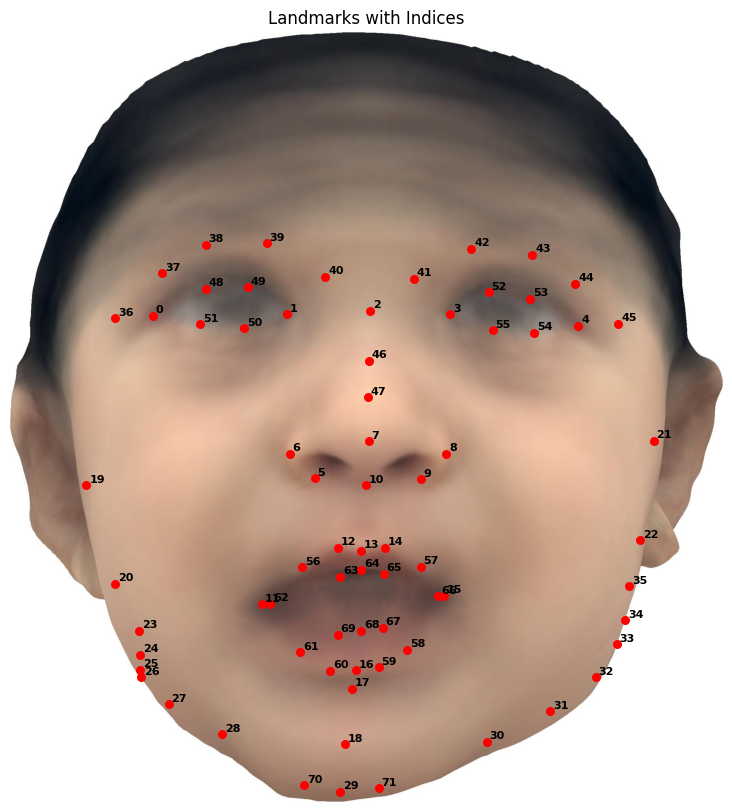

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_landmarks(image_path, keypoints_file, output_image_path=None, show_names=True):
    """
    Plot landmarks on an image with either their corresponding names or indices to help identify each landmark position.
    
    Args:
        image_path (str): Path to the image file.
        keypoints_file (str): Path to the keypoints file (.txt) containing landmark coordinates.
        output_image_path (str, optional): Path to save the output image with labeled landmarks.
                                           If not provided, the image will not be saved.
        show_names (bool, optional): If True, show landmark names. If False, show indices.
    """
    # List of landmark names
    landmark_names = [
        'exR', 'enR', 'n', 'enL', 'exL', 'acR', 'aR', 'prn', 'aL', 'acL', 'sn',
        'chR', 'cphR', 'ls', 'cphL', 'chL', 'li', 'sl', 'pg', 'tR', 'oiR', 'tL', 'oiL',
        'faceO_23', 'faceO_24', 'faceO_25', 'faceO_26', 'faceO_27', 
        'faceO_28', 'chin_29', 'faceO_30', 'faceO_31', 'faceO_32', 
        'faceO_33', 'faceO_34', 'faceO_35', 'rightEB_36', 'rightEB_37', 
        'rightEB_38', 'rightEB_39', 'rightEB_40', 'leftEB_41', 
        'leftEB_42', 'leftEB_43', 'leftEB_44', 'leftEB_45', 'nose_46', 
        'nose_47', 'rightE_48', 'rightE_49', 'rightE_50', 'rightE_51', 'leftE_52', 
        'leftE_53', 'leftE_54', 'leftE_55', 'upperL_56', 'upperL_57', 'lowerL_58', 
        'lowerL_59', 'lowerL_60', 'lowerL_61', 'lipE_62', 'upperL_63', 'upperL_64', 
        'upperL_65', 'lipE_66', 'lowerL_67', 'lowerL_68', 'lowerL_69', 'chin_70', 'chin_71'
    ]

    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the keypoints from the file
    with open(keypoints_file, 'r') as f:
        keypoints_data = f.readline().strip().split()

        # Check if the format is: class_idx cx cy w h x1 y1 ... xn yn
        if len(keypoints_data) == 149:  # 1 class_idx + 4 bbox values + 144 landmark values
            keypoints = np.array(keypoints_data[5:], dtype=np.float32).reshape(-1, 2)  # Ignoring class_idx and bbox
        else:  # Format is: class_idx x1 y1 ... xn yn
            keypoints = np.array(keypoints_data[1:], dtype=np.float32).reshape(-1, 2)  # Ignoring class_idx

    # Adjust figure size for better visibility
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    
    # Plot landmarks and label them with either names or indices
    for idx, (x, y) in enumerate(keypoints):
        x_pixel = int(x * image.shape[1])  # Denormalize the x-coordinate to image scale
        y_pixel = int(y * image.shape[0])  # Denormalize the y-coordinate to image scale
        plt.scatter(x_pixel, y_pixel, color='red', s=30)

        # Offset the text position slightly to avoid overlap with the points
        offset = 8
        if show_names:
            plt.text(x_pixel + offset, y_pixel - offset, landmark_names[idx], fontsize=8, color='black', fontweight='bold')
        else:
            plt.text(x_pixel + offset, y_pixel - offset, str(idx), fontsize=8, color='black', fontweight='bold')

    plt.title('Landmarks with Names' if show_names else 'Landmarks with Indices')
    plt.axis('off')

    # Save the image if output path is provided
    if output_image_path:
        plt.savefig(output_image_path)
    
    # Show the plot
    plt.show()



# Example usage
image_path = "/Users/jocareher/Downloads/synthetic_lmks_dataset/train/images/synthetic_shape_00002_frontal.jpg"
keypoints_file = "/Users/jocareher/Downloads/synthetic_lmks_dataset/train/labels/synthetic_shape_00002_frontal.txt"
output_image_path = "/Users/jocareher/Downloads/labeled_frontal_n.jpg"  # Optional, can be None

plot_landmarks(image_path, keypoints_file, output_image_path, show_names=False)


In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def calculate_nme_intraocular_per_class(groundtruth_dir, predictions_dir):
    """
    Calculate the Normalized Mean Error (NME) using the intraocular distance for normalization
    and accumulate errors per class.
    
    Args:
        groundtruth_dir (str): Path to the directory containing groundtruth keypoints.
        predictions_dir (str): Path to the directory containing predicted keypoints.

    Returns:
        nme_per_class (dict): Dictionary where keys are class_idx and values are lists of NME per landmark.
        landmark_errors_per_class (dict): Dictionary where keys are class_idx and values are
                                          lists of NME for each landmark.
        overall_landmark_errors (list): List of NME values for each landmark across all images (for overall plot).
    """
    groundtruth_files = sorted(os.listdir(groundtruth_dir))
    prediction_files = sorted(os.listdir(predictions_dir))

    # Initialize dictionaries and lists to store NME for each class
    nme_per_class = {i: [] for i in range(5)}  # Assuming class_idx is between 0 and 4
    landmark_errors_per_class = {i: [[] for _ in range(72)] for i in range(5)}  # Assuming 72 landmarks
    overall_landmark_errors = [[] for _ in range(72)]  # For general boxplot

    # Landmarks around the eyes (using 0-based indices)
    left_eye_indices = [0, 1, 48, 49, 50, 51]  # Left eye landmarks
    right_eye_indices = [3, 4, 52, 53, 54, 55]  # Right eye landmarks

    # Loop through all groundtruth and prediction files
    for gt_file, pred_file in zip(groundtruth_files, prediction_files):
        gt_path = os.path.join(groundtruth_dir, gt_file)
        pred_path = os.path.join(predictions_dir, pred_file)

        try:
            # Load groundtruth and predictions
            with open(gt_path, 'r') as f_gt:
                gt_data = f_gt.readline().strip().split()
                class_idx = int(gt_data[0])  # Extract class_idx from groundtruth
                gt_keypoints = np.array(gt_data[5:], dtype=np.float32).reshape(-1, 3)[:, :2]  # Ignore bbox and visibility

            with open(pred_path, 'r') as f_pred:
                pred_data = f_pred.readline().strip().split()
                pred_keypoints = np.array(pred_data[1:], dtype=np.float32).reshape(-1, 3)[:, :2]  # Ignore class_idx and visibility

            # Check if the number of landmarks matches
            if gt_keypoints.shape != pred_keypoints.shape:
                if gt_keypoints.shape[0] > 72:
                    gt_keypoints = gt_keypoints[:72]
                if pred_keypoints.shape[0] > 72:
                    pred_keypoints = pred_keypoints[:72]
                if gt_keypoints.shape[0] < 72 or pred_keypoints.shape[0] < 72:
                    continue

            # Calculate the centroid of the eyes
            left_eye_center = np.mean(gt_keypoints[left_eye_indices], axis=0)
            right_eye_center = np.mean(gt_keypoints[right_eye_indices], axis=0)

            # Calculate intraocular distance
            intraocular_distance = np.linalg.norm(left_eye_center - right_eye_center)

            # Calculate NME for each landmark
            errors = np.linalg.norm(gt_keypoints - pred_keypoints, axis=1) / intraocular_distance

            # Accumulate errors for the corresponding class
            for i, error in enumerate(errors):
                landmark_errors_per_class[class_idx][i].append(error)
                overall_landmark_errors[i].append(error)  # Also accumulate for general plot

        except Exception as e:
            print(f"Error processing {gt_file}: {e}")
            continue

    # Calculate the mean NME per class
    for class_idx, errors in landmark_errors_per_class.items():
        nme_per_class[class_idx] = [np.mean(landmark_error) for landmark_error in errors]

    return nme_per_class, landmark_errors_per_class, overall_landmark_errors


def plot_landmark_error_boxplot_per_class(landmark_errors_per_class, overall_landmark_errors, output_image_path=None, show_names=True):
    """
    Plot boxplots of the Normalized Mean Error (NME) per class and overall using a logarithmic scale.
    """
    epsilon = 1e-9  # Small value to avoid log(0)

    # List of landmark names
    landmark_names = [
        'exR', 'enR', 'n', 'enL', 'exL', 'acR', 'aR', 'prn', 'aL', 'acL', 'sn',
        'chR', 'cphR', 'ls', 'cphL', 'chL', 'li', 'sl', 'pg', 'tR', 'oiR', 'tL', 'oiL',
        'faceO_23', 'faceO_24', 'faceO_25', 'faceO_26', 'faceO_27', 
        'faceO_28', 'chin_29', 'faceO_30', 'faceO_31', 'faceO_32', 
        'faceO_33', 'faceO_34', 'faceO_35', 'rightEB_36', 'rightEB_37', 
        'rightEB_38', 'rightEB_39', 'rightEB_40', 'leftEB_41', 
        'leftEB_42', 'leftEB_43', 'leftEB_44', 'leftEB_45', 'nose_46', 
        'nose_47', 'rightE_48', 'rightE_49', 'rightE_50', 'rightE_51', 'leftE_52',
        'leftE_53', 'leftE_54', 'leftE_55', 'upperL_56', 'upperL_57', 'lowerL_58', 
        'lowerL_59', 'lowerL_60', 'lowerL_61', 'lipE_62', 'upperL_63', 'upperL_64', 
        'upperL_65', 'lipE_66', 'lowerL_67', 'lowerL_68', 'lowerL_69', 'chin_70', 'chin_71'
    ]

    for class_idx, landmark_errors in landmark_errors_per_class.items():
        landmark_errors = [[max(e, epsilon) for e in lm_errors] for lm_errors in landmark_errors]

        plt.figure(figsize=(24, 14), dpi=120)
        box = plt.boxplot(
            landmark_errors, showfliers=True, showmeans=True, meanline=True, patch_artist=True,
            boxprops=dict(facecolor=cm.Blues(0.4), color='blue'),
            medianprops=dict(color='red', linewidth=2),
            meanprops=dict(color='green', linewidth=2),
            whiskerprops=dict(color='blue', linestyle='--'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='o', color='purple', alpha=0.5)
        )

        plt.yscale("log")
        plt.xlabel("Landmarks", fontsize=12)
        plt.ylabel("NME (Log Scale)", fontsize=12)
        plt.title(f"NME per Landmark - Class {class_idx} (Log Scale)", fontsize=14)
        
        if show_names:
            plt.xticks(range(1, 73), landmark_names, rotation=90, fontsize=9)
        else:
            plt.xticks(range(1, 73), [f'LM_{i}' for i in range(72)], rotation=90, fontsize=9)
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(
            [box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]],
            ['Boxes (IQR)', 'Median', 'Mean', 'Outliers'],
            loc='lower right', fontsize=10, frameon=True
        )
        
        if output_image_path:
            plt.savefig(f"{output_image_path}_class_{class_idx}_log.png", bbox_inches="tight")
        
        plt.show()

    overall_landmark_errors = [[max(e, epsilon) for e in lm_errors] for lm_errors in overall_landmark_errors]

    plt.figure(figsize=(24, 14), dpi=120)
    box = plt.boxplot(
        overall_landmark_errors, showfliers=True, showmeans=True, meanline=True, patch_artist=True,
        boxprops=dict(facecolor=cm.Blues(0.4), color='blue'),
        medianprops=dict(color='red', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        whiskerprops=dict(color='blue', linestyle='--'),
        capprops=dict(color='blue'),
        flierprops=dict(marker='o', color='purple', alpha=0.5)
    )

    plt.yscale("log")
    plt.ylim([1e-4, 3.0])
    plt.xlabel("Landmarks", fontsize=12)
    plt.ylabel("NME (Log Scale)", fontsize=12)
    plt.title("NME per Landmark - Overall (Log Scale)", fontsize=14)
    
    if show_names:
        plt.xticks(range(1, 73), landmark_names, rotation=90, fontsize=9)
    else:
        plt.xticks(range(1, 73), [f'LM_{i}' for i in range(72)], rotation=90, fontsize=9)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(
        [box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]],
        ['Boxes (IQR)', 'Median', 'Mean', 'Outliers'],
        loc='lower right', fontsize=10, frameon=True
    )
    
    if output_image_path:
        plt.savefig(f"{output_image_path}_overall_log.png", bbox_inches="tight")
    
    plt.show()

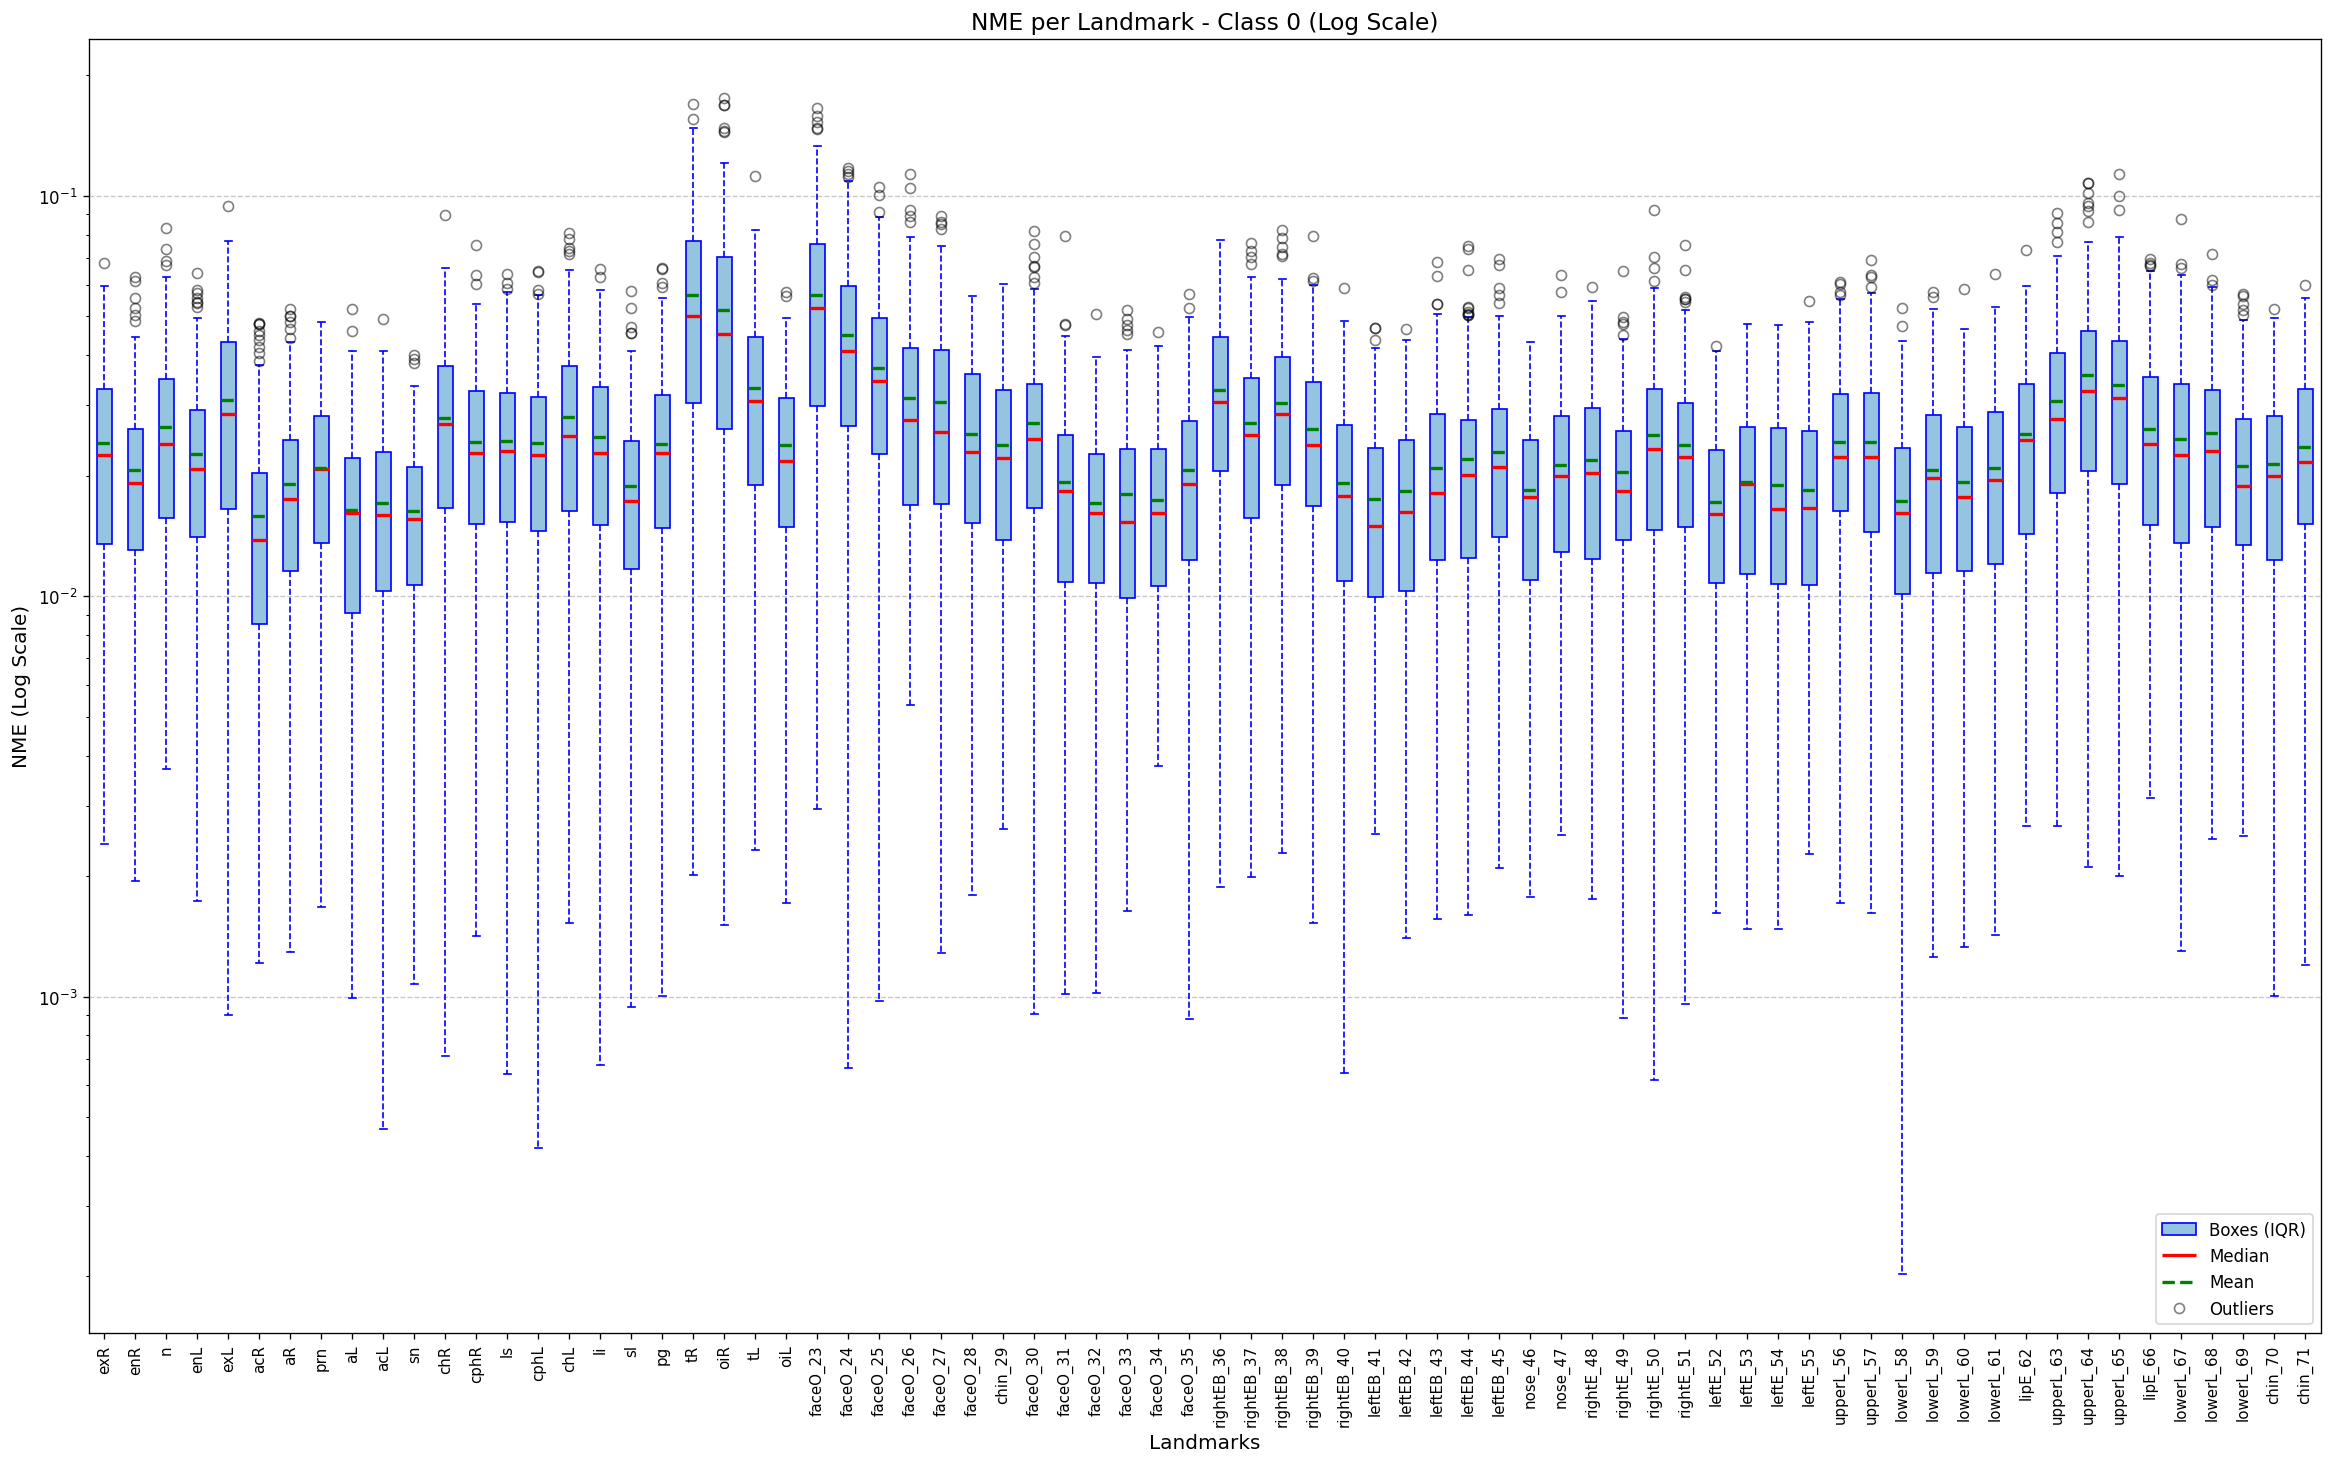

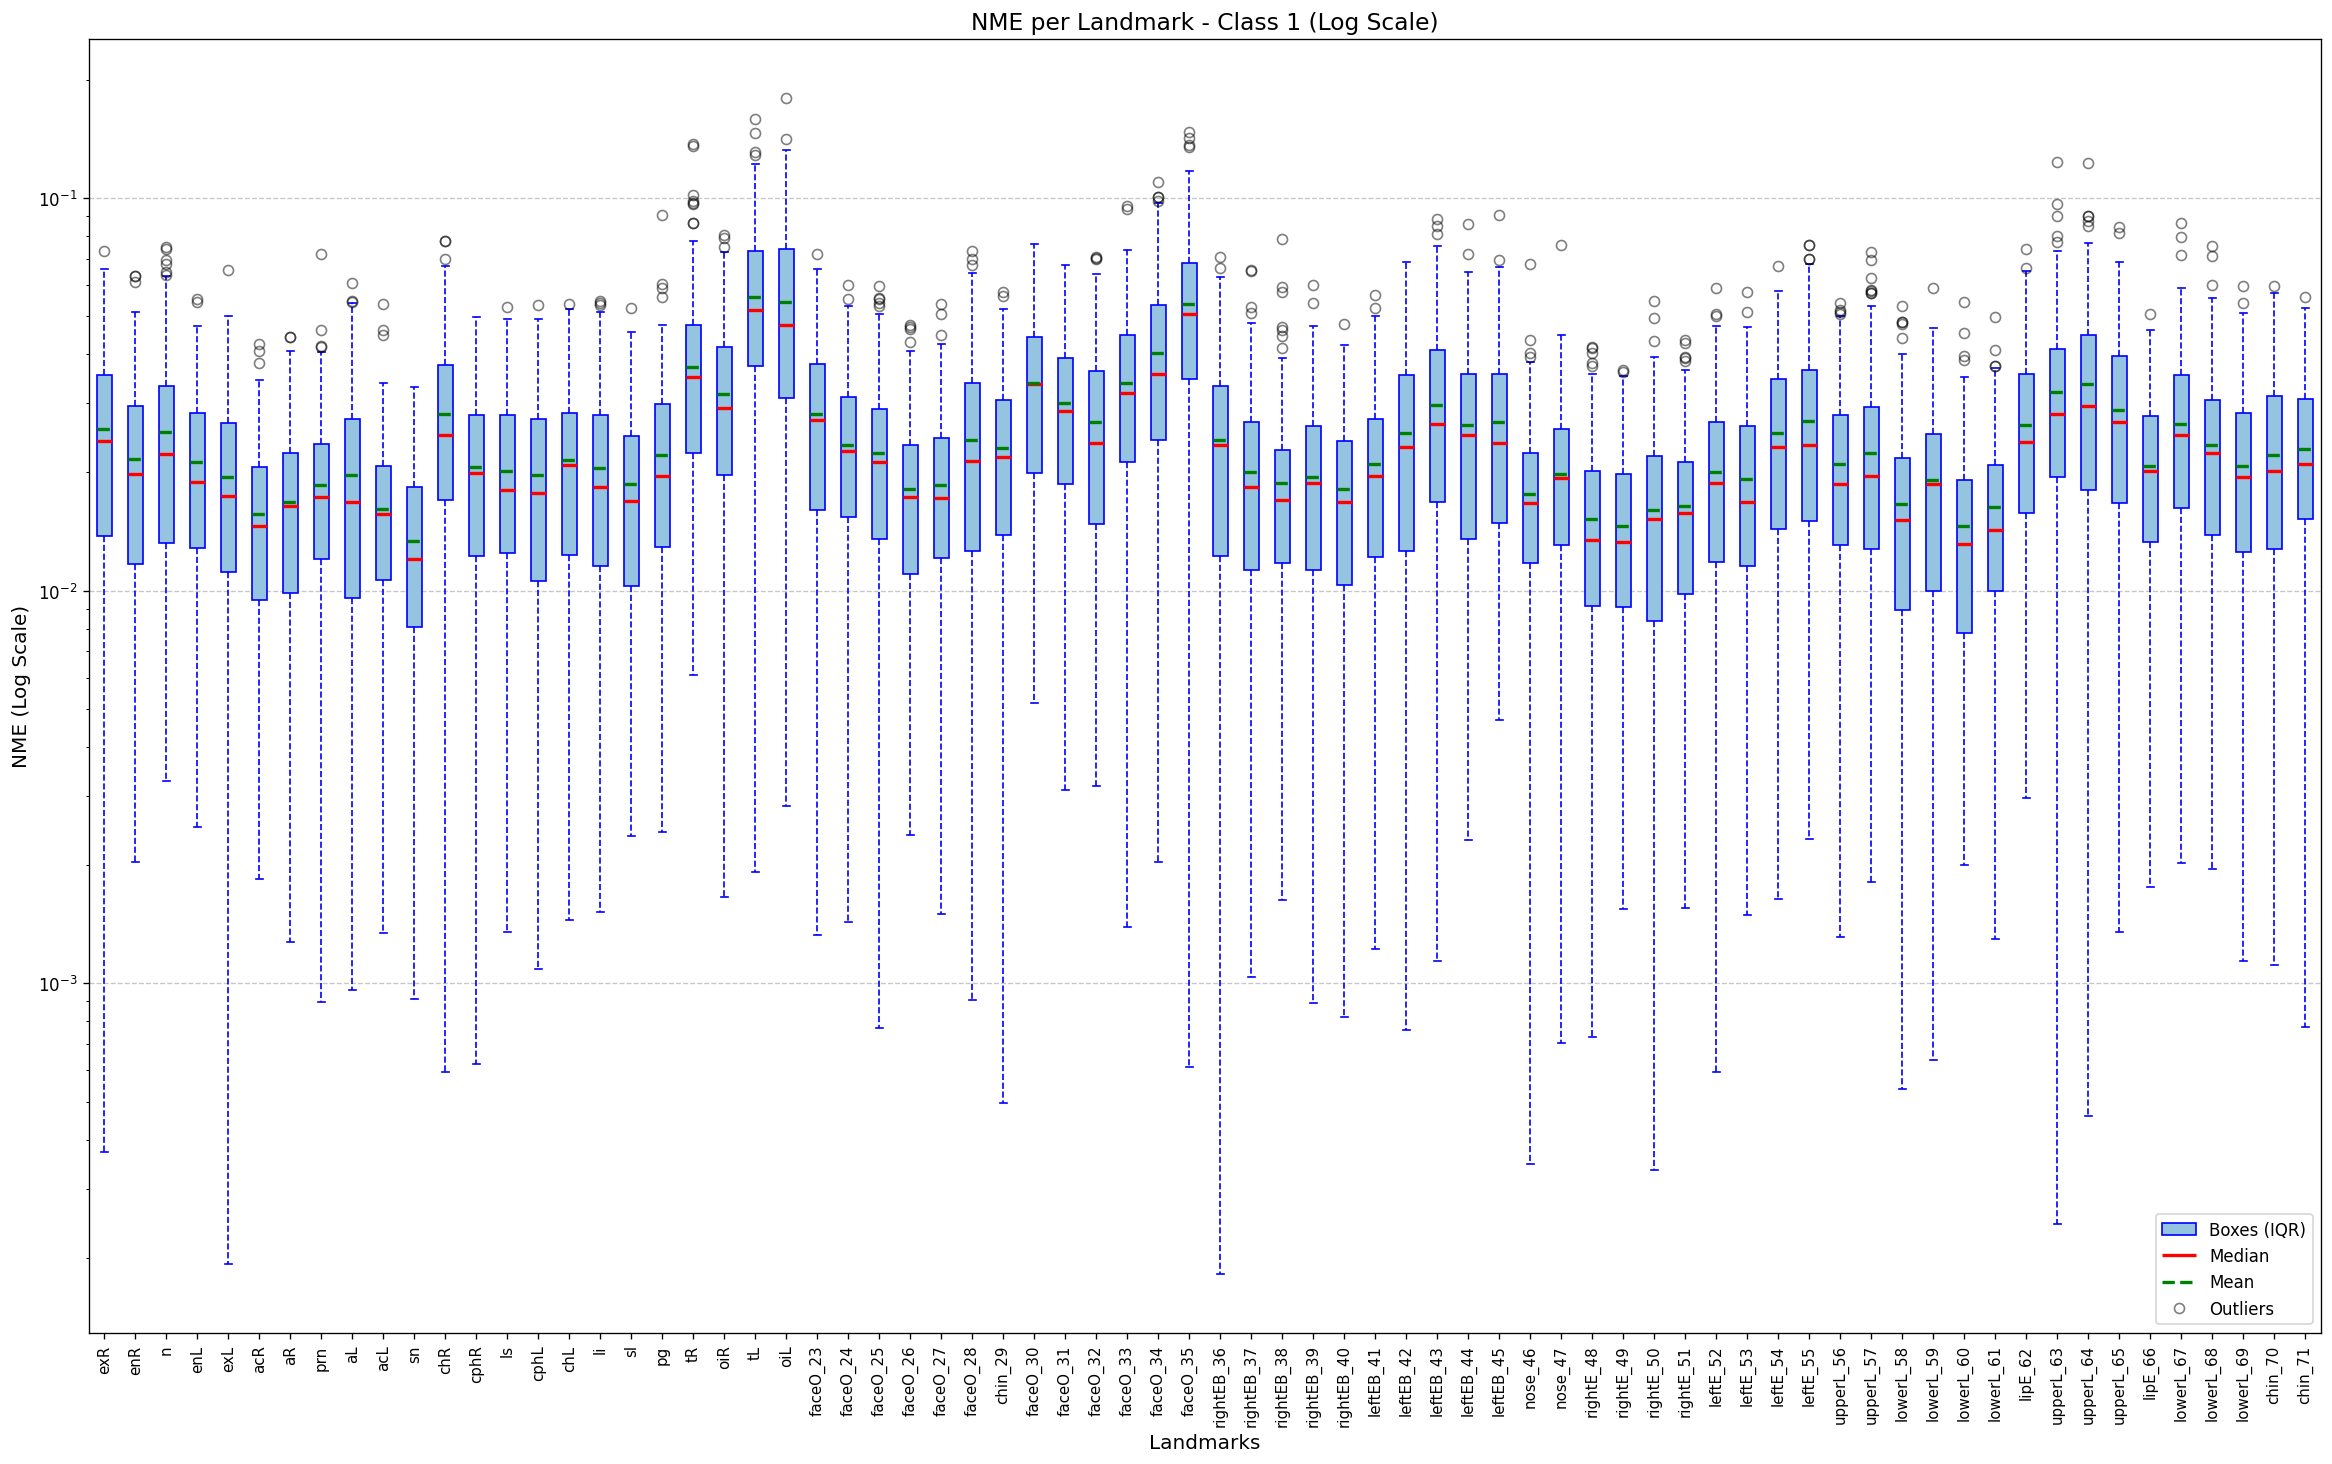

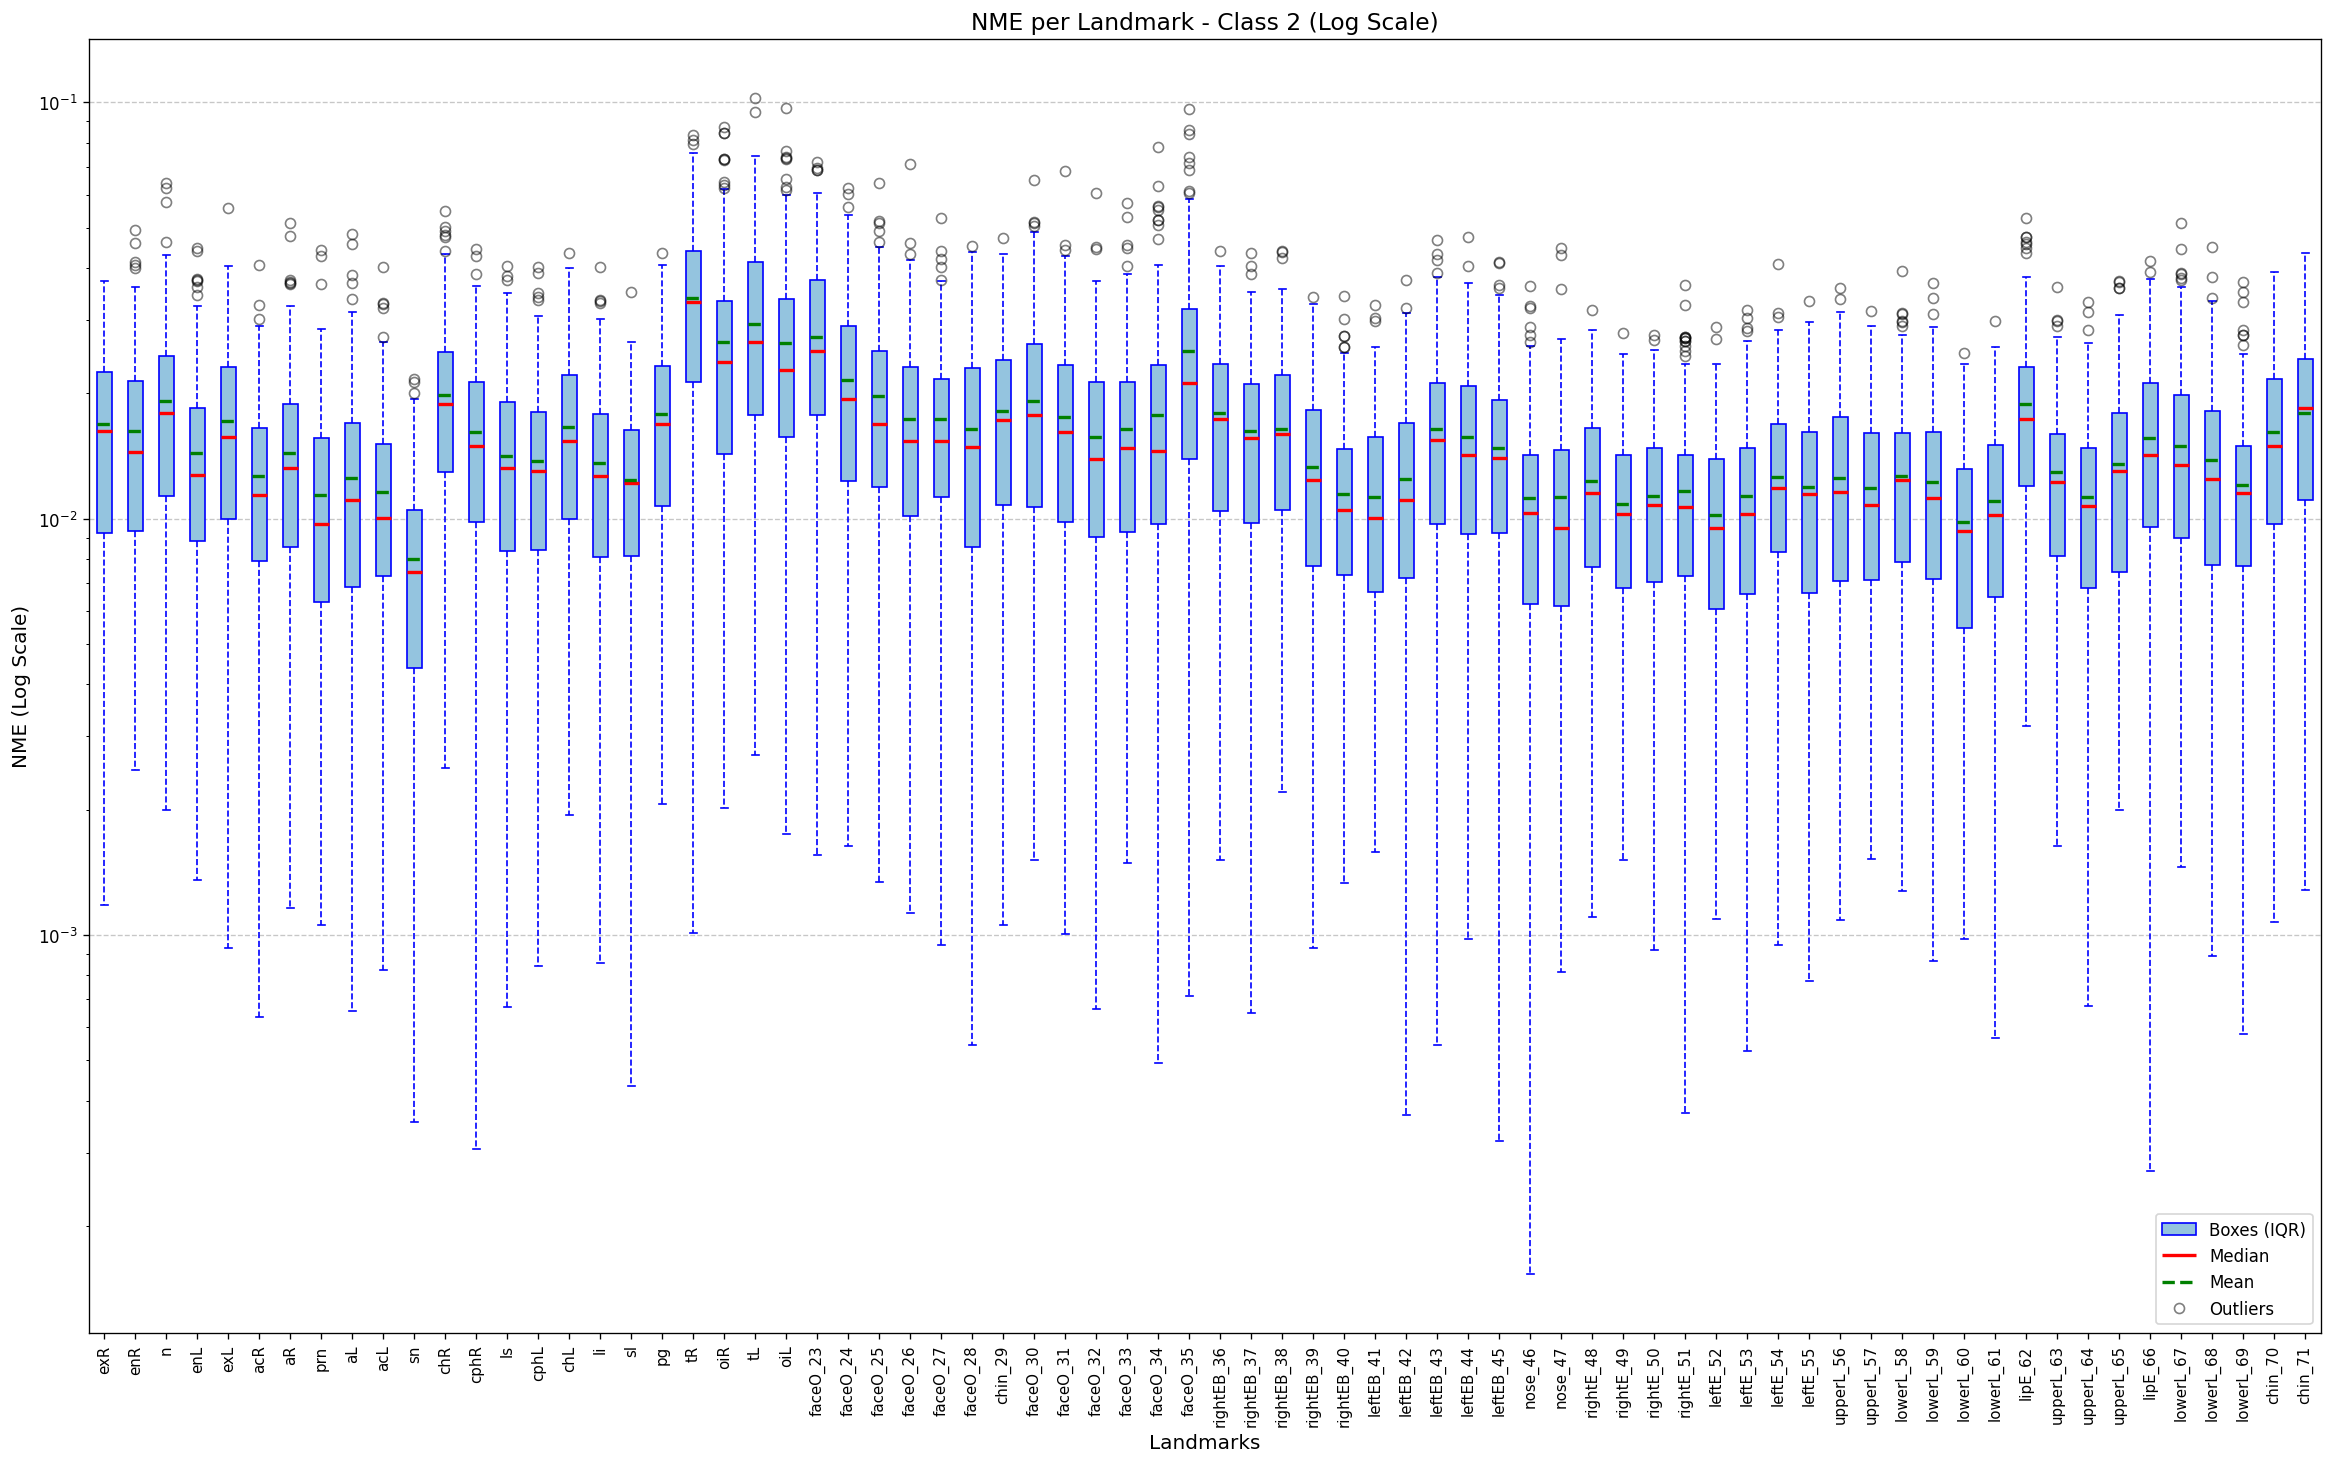

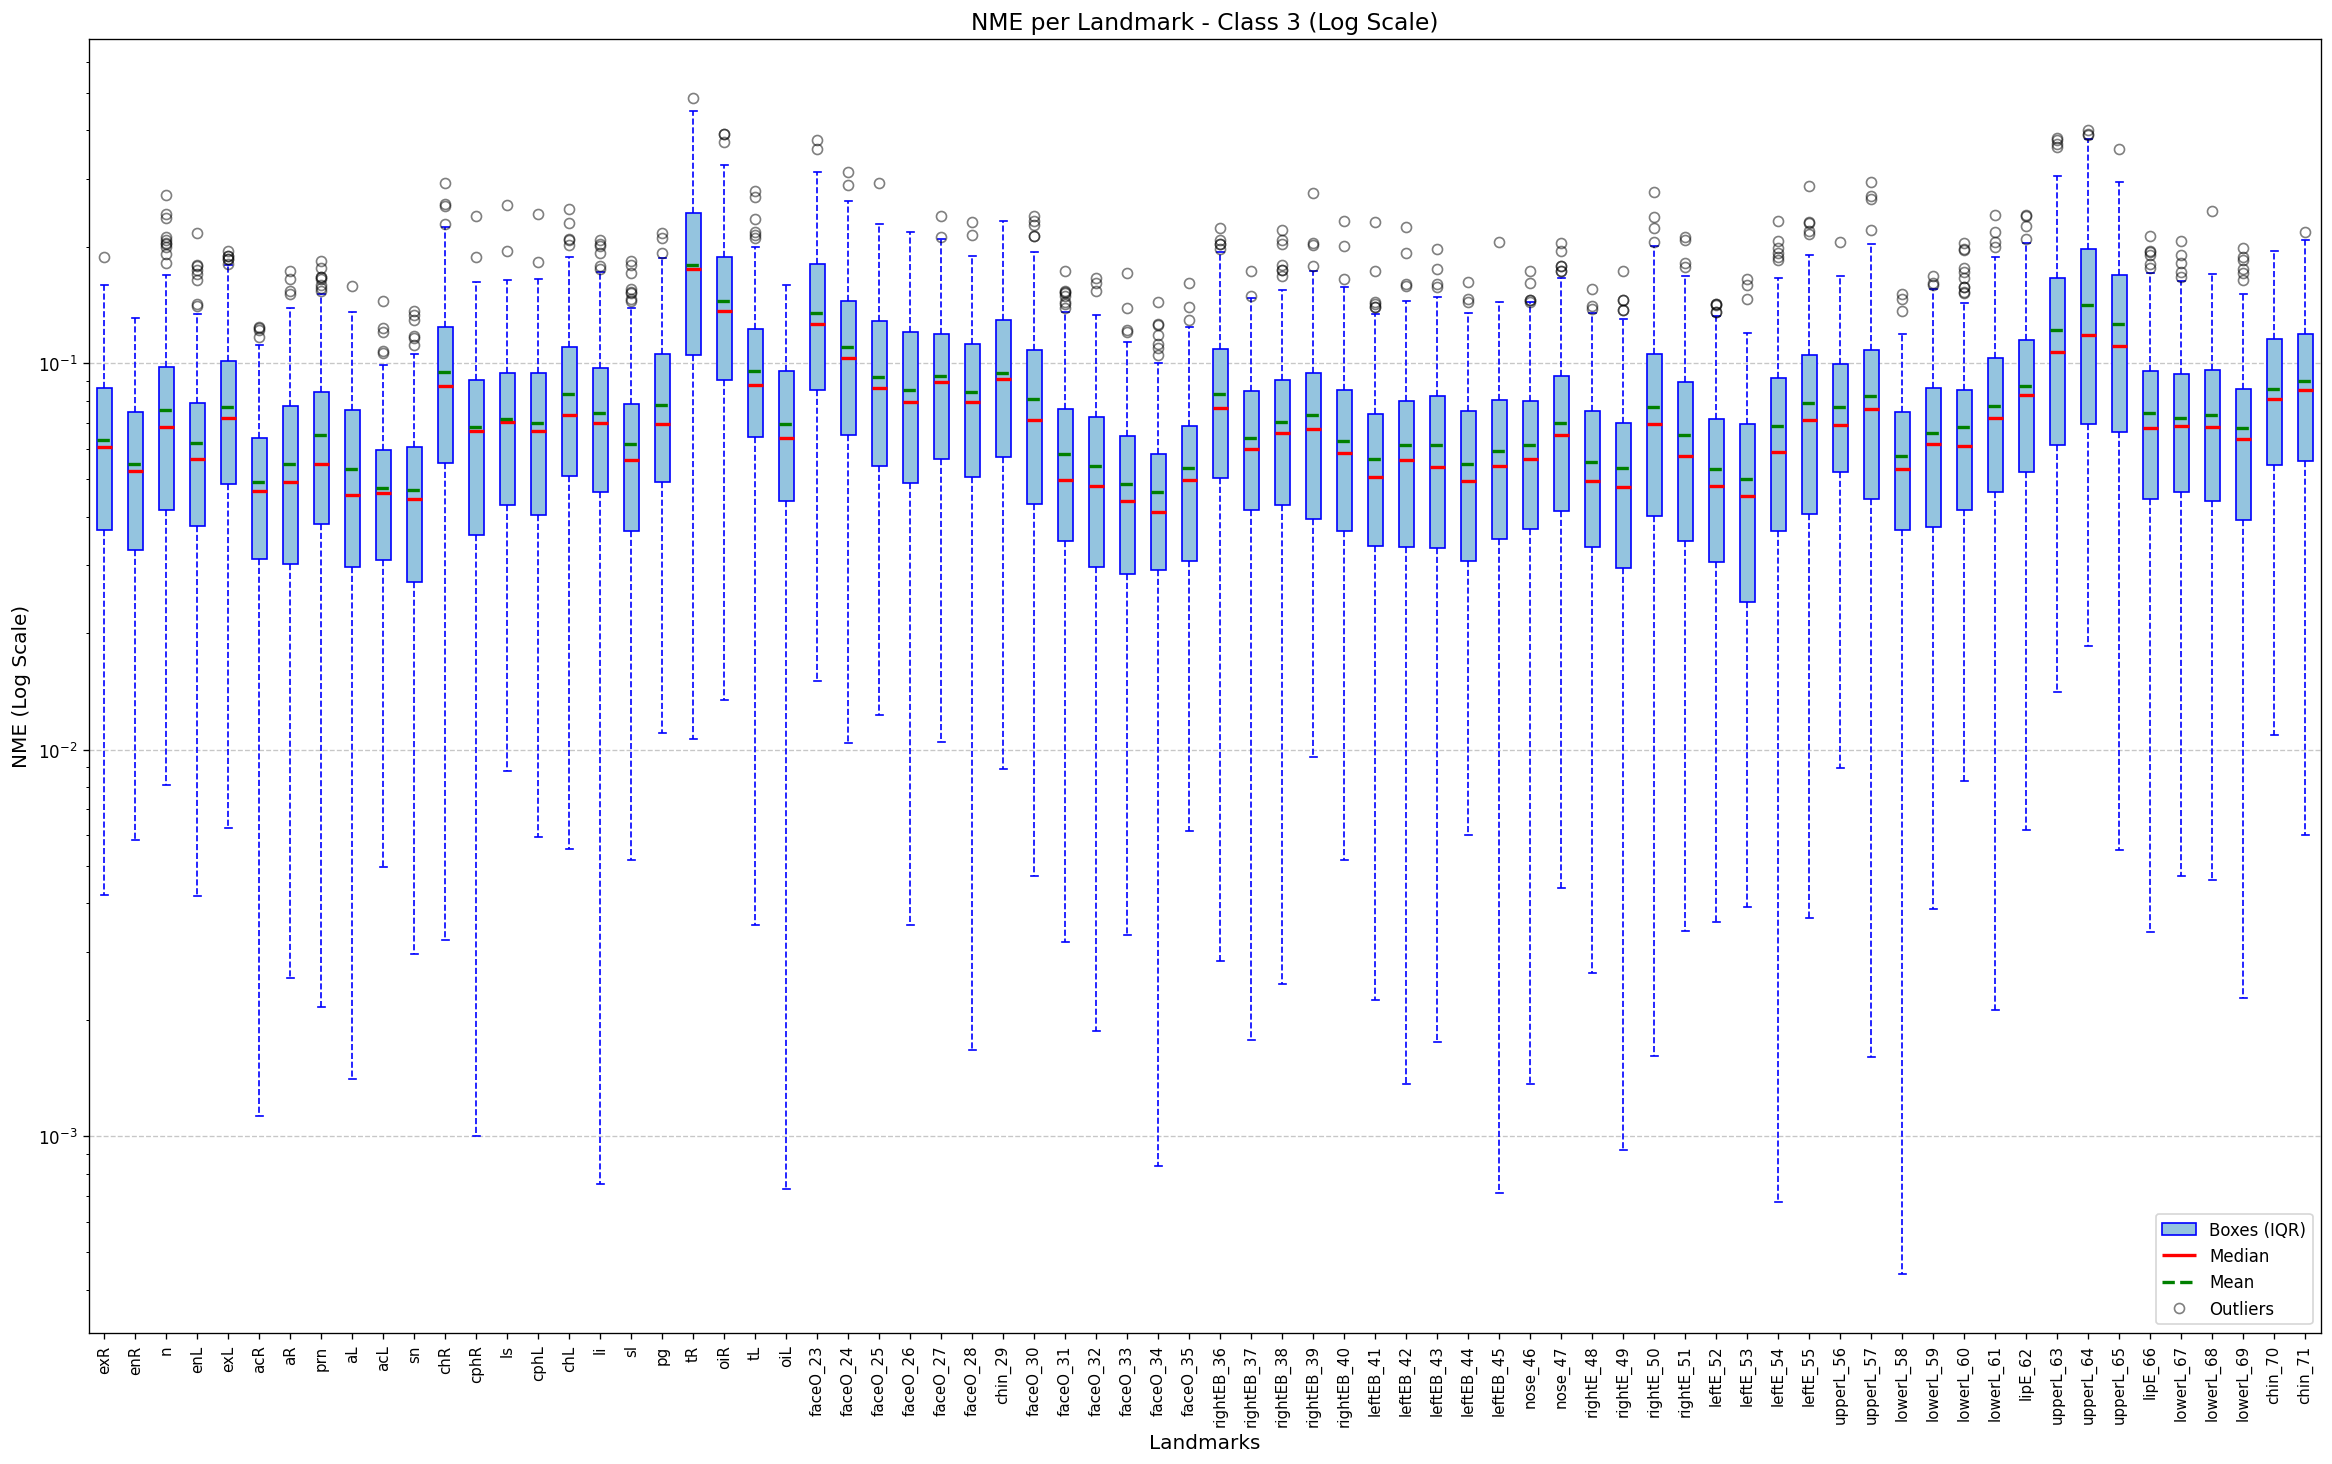

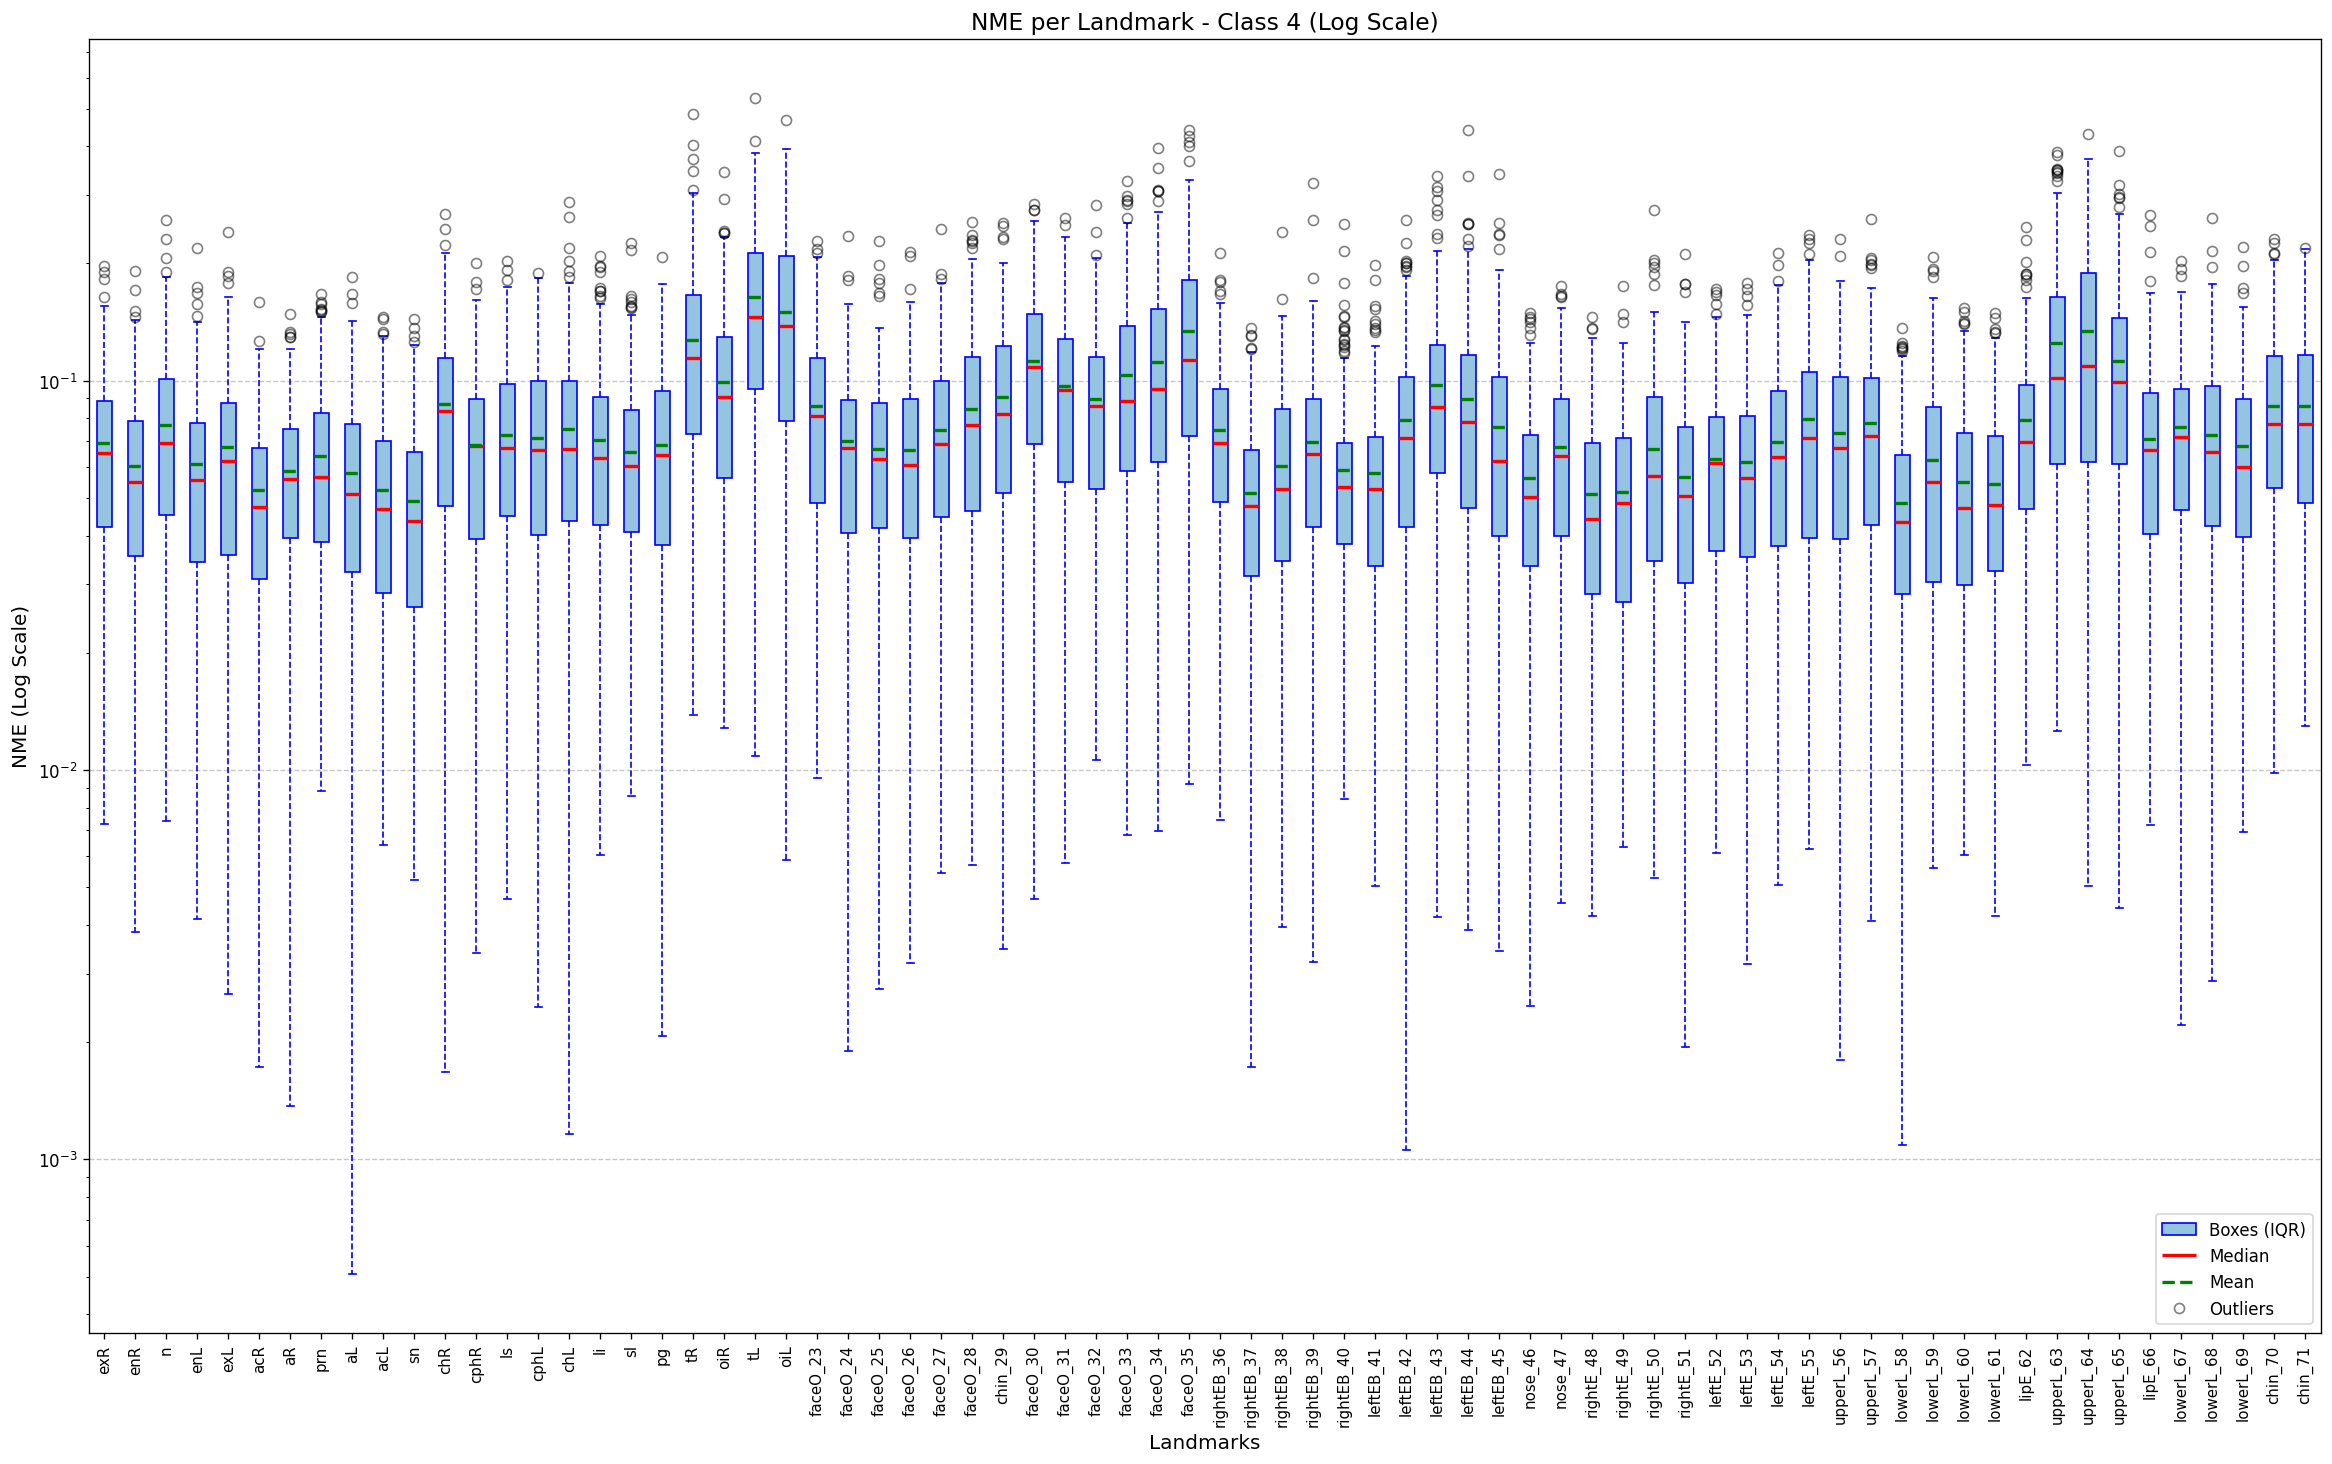

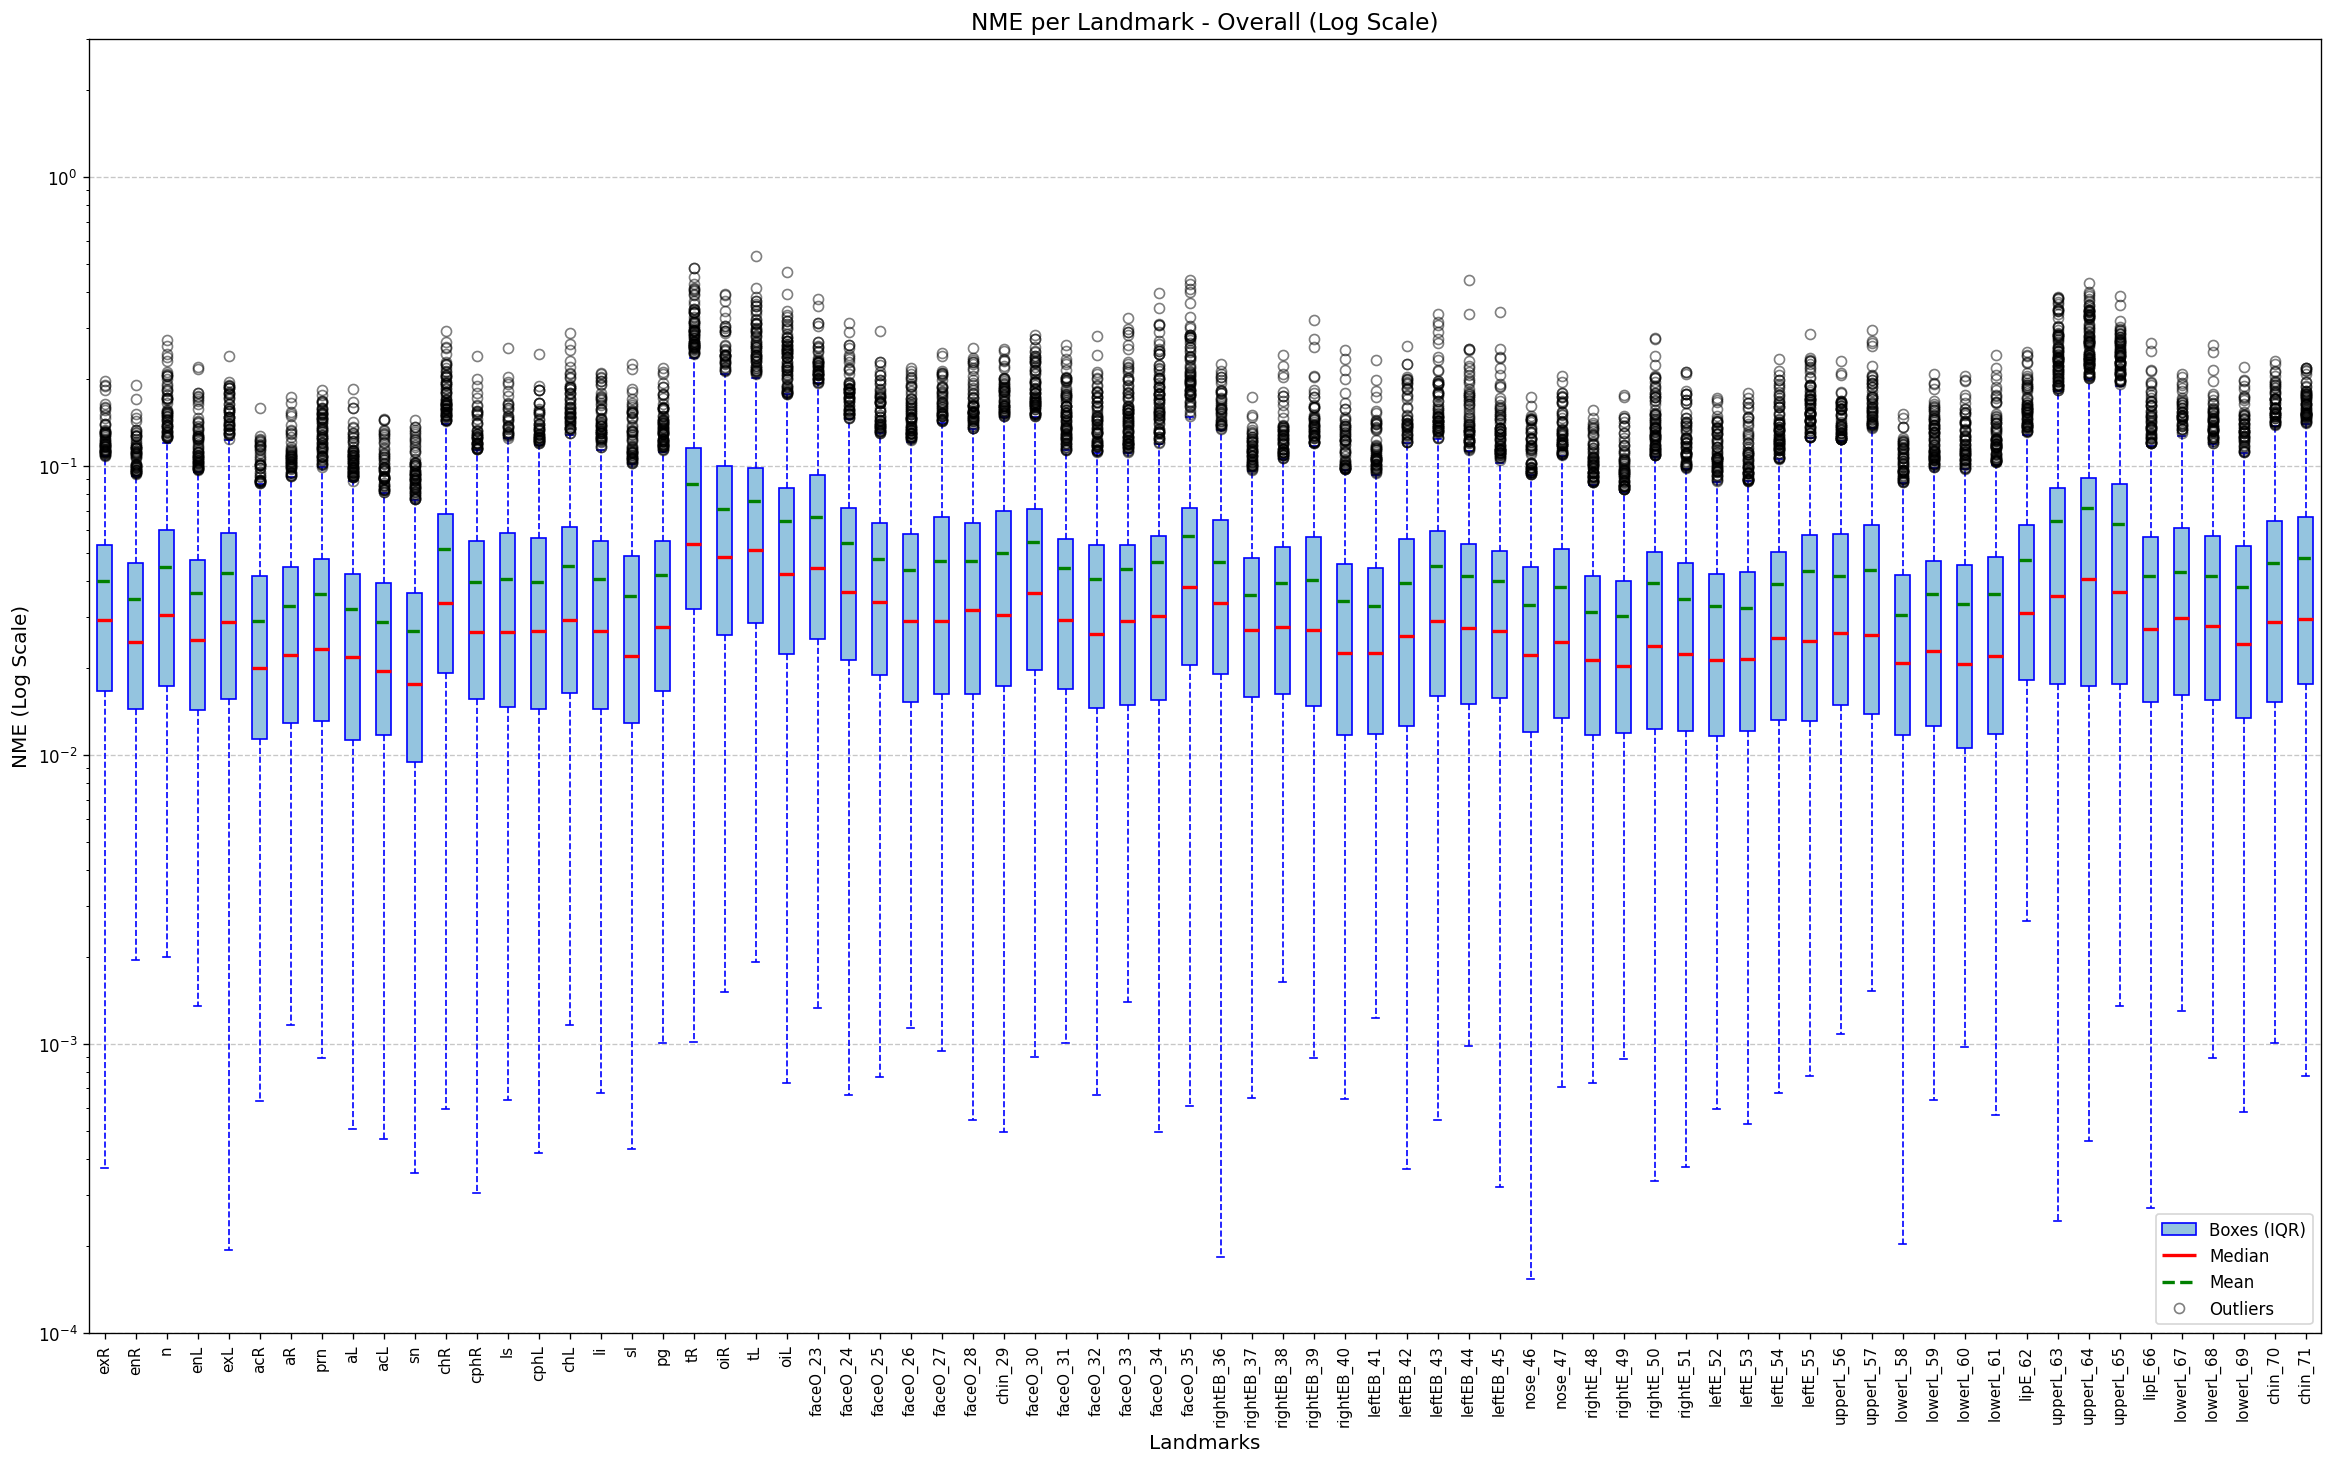

In [24]:
# Paths for groundtruth and prediction directories
groundtruth_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/labels"  # Example path to groundtruth
predictions_dir = "/Users/jocareher/Downloads/last_model_synt/labels"  # "/Users/jocareher/Downloads/pose_pred_vis/labels"
nme_per_class, landmark_errors_per_class, overall_landmark_errors = calculate_nme_intraocular_per_class(groundtruth_dir, predictions_dir)
plot_landmark_error_boxplot_per_class(landmark_errors_per_class, overall_landmark_errors, output_image_path="nme_boxplot", show_names=True)


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def generate_confusion_matrices_with_metrics(groundtruth_dir, predictions_dir, output_dir=None, threshold=0.5):
    """
    Generate confusion matrices with detailed metrics for visibility predictions per class and overall.

    Args:
        groundtruth_dir (str): Path to the directory containing groundtruth files.
        predictions_dir (str): Path to the directory containing predicted files.
        output_dir (str, optional): Path to save the confusion matrix plots.
        threshold (float): Confidence threshold to classify predictions as visible or occluded.

    Returns:
        dict: Confusion matrices and classification reports for each class and overall.
    """
    groundtruth_files = sorted(os.listdir(groundtruth_dir))
    prediction_files = sorted(os.listdir(predictions_dir))

    class_metrics = {}
    overall_groundtruth = []
    overall_predictions = []

    for class_idx in range(5):
        gt_labels = []
        pred_labels = []

        for gt_file, pred_file in zip(groundtruth_files, prediction_files):
            gt_path = os.path.join(groundtruth_dir, gt_file)
            pred_path = os.path.join(predictions_dir, pred_file)

            with open(gt_path, 'r') as f_gt, open(pred_path, 'r') as f_pred:
                gt_data = f_gt.readline().strip().split()
                pred_data = f_pred.readline().strip().split()

                if int(gt_data[0]) != class_idx:
                    continue  # Skip files not belonging to the current class

                # Extract visibility labels
                gt_visibilities = np.array(gt_data[5:], dtype=np.float32).reshape(-1, 3)[:, 2]
                pred_confidences = np.array(pred_data[1:], dtype=np.float32).reshape(-1, 3)[:, 2]

                # Convert confidences to binary predictions
                gt_binary = (gt_visibilities == 2).astype(int)  # 2 = visible, 1 = occluded
                pred_binary = (pred_confidences >= threshold).astype(int)

                gt_labels.extend(gt_binary)
                pred_labels.extend(pred_binary)

                # Accumulate for overall confusion matrix
                overall_groundtruth.extend(gt_binary)
                overall_predictions.extend(pred_binary)

        # Compute confusion matrix and metrics
        cm = confusion_matrix(gt_labels, pred_labels)
        report = classification_report(gt_labels, pred_labels, target_names=["Occluded", "Visible"], digits=2)
        class_metrics[class_idx] = {
            "confusion_matrix": cm,
            "classification_report": report
        }

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(6, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Occluded", "Visible"])
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        plt.title(f"Confusion Matrix - Class {class_idx}")
        plt.grid(False)

        # Save the plot if output directory is provided
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f"confusion_matrix_class_{class_idx}.png"), bbox_inches="tight")

        plt.show()

        # Print metrics to console
        print(f"\nMetrics for Class {class_idx}:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")

    # Compute overall confusion matrix and metrics
    overall_cm = confusion_matrix(overall_groundtruth, overall_predictions)
    overall_report = classification_report(overall_groundtruth, overall_predictions, target_names=["Occluded", "Visible"], digits=2)
    class_metrics["overall"] = {
        "confusion_matrix": overall_cm,
        "classification_report": overall_report
    }

    # Plot overall confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm, display_labels=["Occluded", "Visible"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix - Overall")
    plt.grid(False)

    if output_dir:
        plt.savefig(os.path.join(output_dir, "confusion_matrix_overall.png"), bbox_inches="tight")

    plt.show()

    # Print overall metrics to console
    print("\nOverall Metrics:")
    print(f"Confusion Matrix:\n{overall_cm}")
    print(f"Classification Report:\n{overall_report}")

    return class_metrics

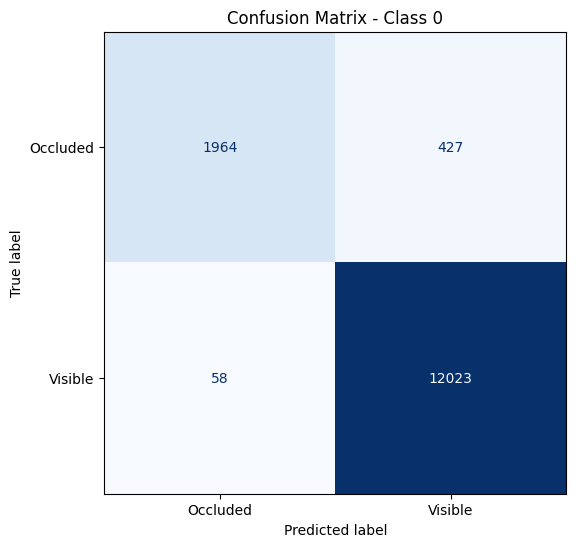


Metrics for Class 0:
Confusion Matrix:
[[ 1964   427]
 [   58 12023]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.97      0.82      0.89      2391
     Visible       0.97      1.00      0.98     12081

    accuracy                           0.97     14472
   macro avg       0.97      0.91      0.94     14472
weighted avg       0.97      0.97      0.97     14472



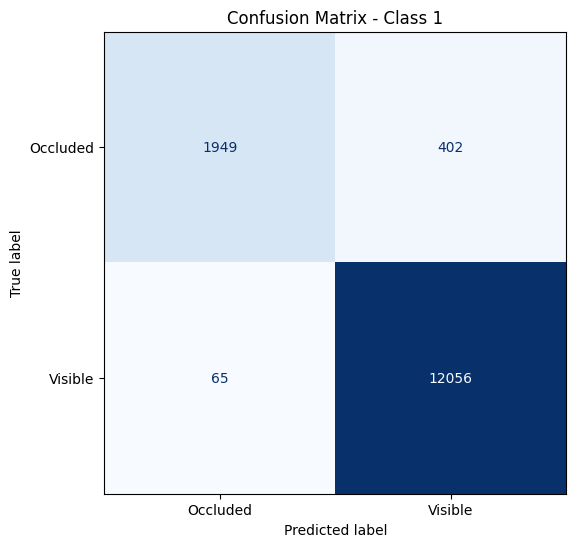


Metrics for Class 1:
Confusion Matrix:
[[ 1949   402]
 [   65 12056]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.97      0.83      0.89      2351
     Visible       0.97      0.99      0.98     12121

    accuracy                           0.97     14472
   macro avg       0.97      0.91      0.94     14472
weighted avg       0.97      0.97      0.97     14472



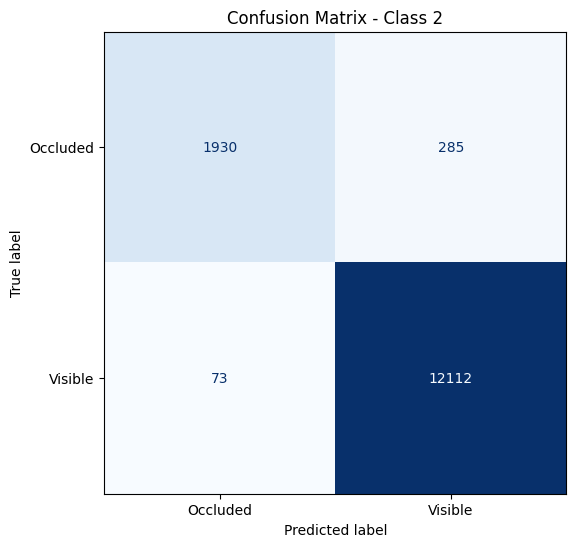


Metrics for Class 2:
Confusion Matrix:
[[ 1930   285]
 [   73 12112]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.96      0.87      0.92      2215
     Visible       0.98      0.99      0.99     12185

    accuracy                           0.98     14400
   macro avg       0.97      0.93      0.95     14400
weighted avg       0.97      0.98      0.97     14400



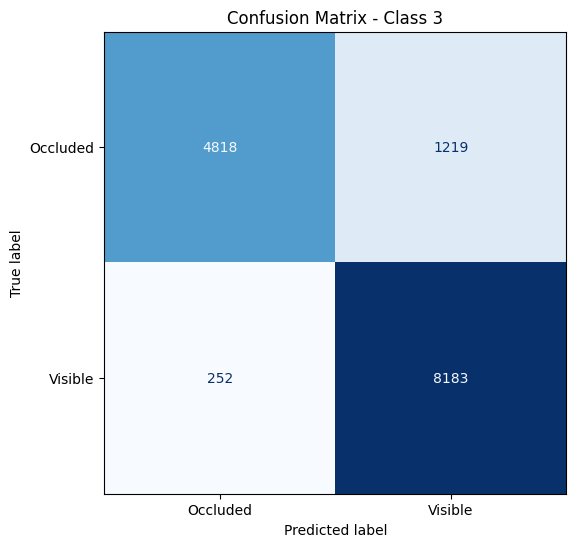


Metrics for Class 3:
Confusion Matrix:
[[4818 1219]
 [ 252 8183]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.95      0.80      0.87      6037
     Visible       0.87      0.97      0.92      8435

    accuracy                           0.90     14472
   macro avg       0.91      0.88      0.89     14472
weighted avg       0.90      0.90      0.90     14472



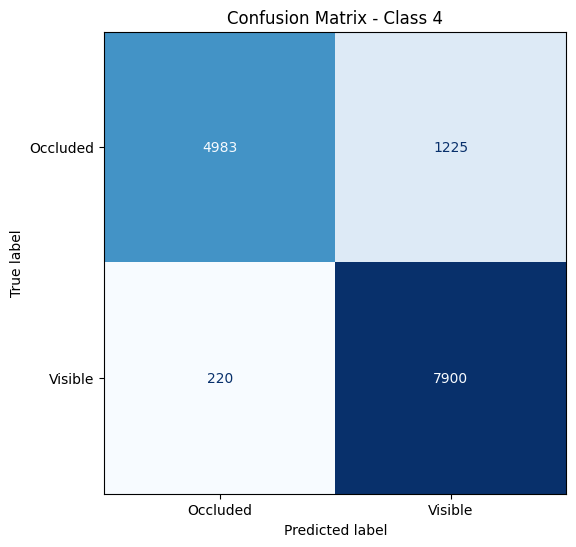


Metrics for Class 4:
Confusion Matrix:
[[4983 1225]
 [ 220 7900]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.96      0.80      0.87      6208
     Visible       0.87      0.97      0.92      8120

    accuracy                           0.90     14328
   macro avg       0.91      0.89      0.89     14328
weighted avg       0.91      0.90      0.90     14328



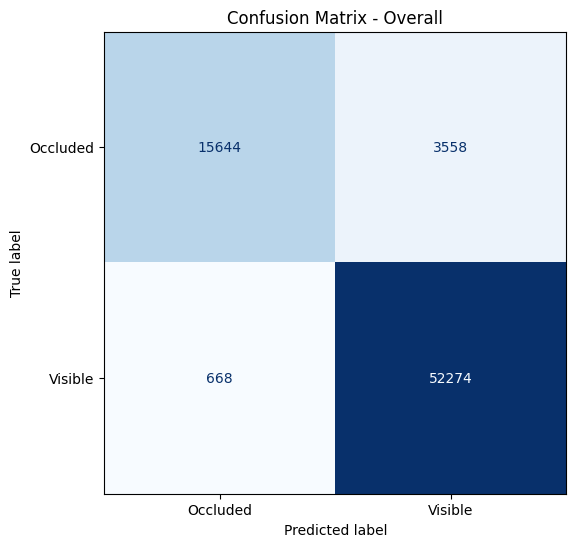


Overall Metrics:
Confusion Matrix:
[[15644  3558]
 [  668 52274]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.96      0.81      0.88     19202
     Visible       0.94      0.99      0.96     52942

    accuracy                           0.94     72144
   macro avg       0.95      0.90      0.92     72144
weighted avg       0.94      0.94      0.94     72144



In [18]:
groundtruth_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/labels"  # Example path to groundtruth
predictions_dir = "/Users/jocareher/Downloads/last_model_synt/labels" 
output_dir = "/Users/jocareher/Downloads"  # Optional

results = generate_confusion_matrices_with_metrics(groundtruth_dir, predictions_dir, output_dir)

In [35]:
import os
import cv2
import math
import numpy as np
from typing import Tuple, List
from ultralytics import YOLO

def plot_keypoints(image: np.ndarray, keypoints: np.ndarray, output_path: str) -> None:
    """
    Draw Nx3 keypoints (x, y, visibility/conf) on 'image' (BGR) and save.
    A point is red if v<0.5, else blue.
    """
    height, width = image.shape[:2]
    diag = float(math.sqrt(width**2 + height**2))
    radius = max(int(diag * 0.0025), 1)  # scale by image size
    thickness = -1  # filled circle

    for (x, y, v) in keypoints:
        x_i, y_i = int(x), int(y)
        color = (255, 0, 0) if v < 0.5 else (0, 0, 255)
        cv2.circle(image, (x_i, y_i), radius, color, thickness)

    cv2.imwrite(output_path, image)
    print(f"Keypoints plotted and saved to {output_path}")

def transform_landmarks(keypoints: np.ndarray, T: np.ndarray, is_perspective: bool=False):
    """
    Inverse transform for Nx3 keypoints [x, y, v]. 
    If is_perspective=True => T is 3x3.
    Else T is 2x3 => (affine).
    """
    if is_perspective:
        kp_hom = np.concatenate([keypoints[:, :2], np.ones((len(keypoints),1))], axis=1)
        kp_trans = kp_hom @ T.T
        kp_trans /= np.clip(kp_trans[:, 2:3], 1e-6, None)
        keypoints[:, 0:2] = kp_trans[:, 0:2]
    else:
        kp_hom = np.concatenate([keypoints[:, :2], np.ones((len(keypoints),1))], axis=1)
        kp_trans = kp_hom @ T.T
        keypoints[:, 0:2] = kp_trans
    return keypoints

def invert_affine_transform(M: np.ndarray) -> np.ndarray:
    """
    Invert a 2x3 affine => another 2x3.
    """
    M_3x3 = np.vstack([M, [0,0,1]])
    M_inv_3x3 = np.linalg.inv(M_3x3)
    return M_inv_3x3[:2, :]

def face_landmark_pipeline(
    input_dir: str,
    output_dir: str,
    face_model_path: str,
    landmark_model_path: str,
    imgsz: int = 640,
    conf: float = 0.50,
    save_cropped_faces: bool = False,
    save_aligned_faces: bool = False,
    alignment_method: str = 'none',   # {"none", "rotate", "perspective"}
    dimension_method: str = 'obb',    # {"obb", "fixed"} 
    fixed_size: Tuple[int, int] = (256, 256)
) -> None:
    """
    A pipeline that:
      1) Detects faces with OBB
      2) Crops them 
      3) Depending on alignment_method => no rotation, rotate, or perspective
      4) Possibly resize if dimension_method == 'fixed', even for 'none'
      5) Landmark detection 
      6) Inverse transform landmarks to original image

    Args:
      dimension_method: 
         - 'obb' => use the boundingRect size from OBB
         - 'fixed' => scale the cropped face to 'fixed_size' even if alignment='none'
    """

    def get_rotation_matrix_and_size(obb_pts: np.ndarray):
        """Pivot at obb_pts[0], compute angle, boundingRect => (rw, rh)."""
        (x1, y1), (x2, y2), (x3, y3), (x4, y4) = obb_pts
        dx, dy = (x2 - x1), (y2 - y1)
        angle_degs = np.degrees(np.arctan2(dy, dx))
        M = cv2.getRotationMatrix2D((x1, y1), angle_degs, 1.0)
        # rotate corners => boundingRect
        rot_pts = []
        for (px, py) in obb_pts:
            px2 = M[0,0]*px + M[0,1]*py + M[0,2]
            py2 = M[1,0]*px + M[1,1]*py + M[1,2]
            rot_pts.append([px2,py2])
        rot_pts = np.array(rot_pts, dtype=np.float32)
        rx, ry, rw, rh = cv2.boundingRect(rot_pts)
        # shift so top-left => (0,0)
        M[0,2] -= rx
        M[1,2] -= ry
        return M, (rw, rh)

    def get_perspective_transform_and_size(obb_pts: np.ndarray,
                                           dimension_method: str,
                                           fixed_size: Tuple[int,int]):
        """Return perspective transform from 4 corners. If dimension_method='fixed', use that. else measure from edges."""
        (x1, y1), (x2, y2), (x3, y3), (x4, y4) = obb_pts
        w_top = np.hypot(x2 - x1, y2 - y1)
        w_bot = np.hypot(x3 - x4, y3 - y4)
        h_left = np.hypot(x4 - x1, y4 - y1)
        h_right= np.hypot(x3 - x2, y3 - y2)
        maxW = int(max(w_top, w_bot))
        maxH = int(max(h_left, h_right))
        if dimension_method == 'fixed':
            W, H = fixed_size
        else:
            W, H = maxW, maxH

        src_pts = np.array([(x1,y1),(x2,y2),(x3,y3),(x4,y4)], dtype=np.float32)
        dst_pts = np.array([(0,0),(W-1,0),(W-1,H-1),(0,H-1)], dtype=np.float32)
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        return M, (W, H)

    def invert_persp(M: np.ndarray):
        return np.linalg.inv(M)

    # Load YOLO
    face_model = YOLO(face_model_path)
    landmark_model = YOLO(landmark_model_path)

    # output dirs
    labels_dir = os.path.join(output_dir,'labels')
    images_dir = os.path.join(output_dir,'images')
    aligned_dir = os.path.join(output_dir,'aligned_faces')
    cropped_dir = os.path.join(output_dir,'cropped_faces')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)
    if save_aligned_faces:
        os.makedirs(aligned_dir, exist_ok=True)
    if save_cropped_faces:
        os.makedirs(cropped_dir, exist_ok=True)

    # gather images
    image_files = sorted(
        f for f in os.listdir(input_dir)
        if f.lower().endswith(('.jpg','.jpeg','.png'))
    )

    total_faces_detected = 0
    total_faces_not_detected = 0
    total_faces_with_landmarks = 0
    total_faces_without_landmarks = 0

    for img_file in image_files:
        img_path = os.path.join(input_dir, img_file)
        if not os.path.isfile(img_path):
            continue
        face_results = face_model.predict(
            source=img_path, imgsz=imgsz, conf=conf, save=False
        )
        image = cv2.imread(img_path)
        if image is None:
            continue
        h_img, w_img = image.shape[:2]
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, f"{base_name}.txt")

        face_detected = False

        with open(label_path, 'w') as lbl:
            for face_res in face_results:
                if (face_res.obb is None) or (len(face_res.obb)==0):
                    continue
                # pick best
                best_conf = -1.0
                best_obb = None
                for obb_det in face_res.obb:
                    cval = float(obb_det.conf)
                    if cval > best_conf:
                        best_conf = cval
                        best_obb = obb_det
                if best_obb is None:
                    continue
                face_detected = True
                total_faces_detected += 1

                try:
                    # get corners
                    norm_obb = best_obb.xyxyxyxyn.cpu().numpy().flatten()
                    obb_pts = (norm_obb * np.array([w_img,h_img]*4)).reshape(4,2).astype(np.float32)

                    # Crop boundingRect from original => face_cropped
                    mask = np.zeros((h_img,w_img), dtype=np.uint8)
                    cv2.fillPoly(mask,[obb_pts.astype(int)],255)
                    face_masked = cv2.bitwise_and(image,image,mask=mask)
                    x,y,ww,hh = cv2.boundingRect(obb_pts.astype(int))
                    face_cropped = face_masked[y:y+hh, x:x+ww]

                    if save_cropped_faces:
                        cpath = os.path.join(cropped_dir, f"{base_name}.jpg")
                        cv2.imwrite(cpath, face_cropped)

                    if alignment_method=='none':
                        # we either keep dimension from OBB or use fixed
                        if dimension_method=='fixed':
                            # resize to (fixed_size)
                            Wf, Hf = fixed_size
                            face_aligned = cv2.resize(face_cropped, (Wf,Hf), interpolation=cv2.INTER_LINEAR)
                            # build an inverse transform that unscales + translates
                            # local => scaled => offset => global
                            scale_x = ww/float(Wf)
                            scale_y = hh/float(Hf)
                            # final local point => global:
                            # x' = x*scale_x + X, y' = y*scale_y + Y
                            # => we can build a 2x3 => [ [scale_x,0,X], [0,scale_y,Y] ] but we want the inverse, so:
                            # forward transform was "scale + translate( x,y )"
                            # => so the inverse is " un-translate => un-scale" 
                            # Actually simpler: if face_aligned(0,0) => face_cropped(0,0) => global( X,Y )
                            # to invert, do:
                            #  [ x_global ] = [ scale_x^-1  0  X ] [ x_local ]
                            #  [ y_global ]   [ 0 scale_y^-1 Y ] [ y_local ]
                            # but we want local = scaled coords => final => global
                            # So let's define M_inv: => x_global = x_local*scale_x^-1 + X, etc.
                            # Actually we should define a single matrix which does:
                            #  unscale => + (x, y).
                            # scale_x^-1 = ww/Wf
                            # scale_y^-1 = hh/Hf
                            Sx = ww/float(Wf)
                            Sy = hh/float(Hf)

                            M_inv = np.array([
                                [Sx,  0, x],
                                [0,  Sy, y]
                            ], dtype=np.float32)
                        else:
                            # dimension_method='obb' => no resizing
                            face_aligned = face_cropped
                            # Then the local coords => x-> x+X => M_inv => [1,0,x],[0,1,y]
                            M_inv = np.array([
                                [1,0,x],
                                [0,1,y]
                            ], dtype=np.float32)

                    elif alignment_method=='rotate':
                        # standard code
                        M, (rw, rh) = get_rotation_matrix_and_size(obb_pts)
                        rotated_img = cv2.warpAffine(image,M,(rw,rh))
                        # boundingRect in rotated coords
                        rot_pts = []
                        for (px,py) in obb_pts:
                            rx2 = M[0,0]*px + M[0,1]*py + M[0,2]
                            ry2 = M[1,0]*px + M[1,1]*py + M[1,2]
                            rot_pts.append([rx2,ry2])
                        rot_pts = np.array(rot_pts,dtype=np.float32)
                        rx, ry, rw2, rh2 = cv2.boundingRect(rot_pts)

                        face_aligned = rotated_img[ry:ry+rh2, rx:rx+rw2]

                        M_inv_aff = invert_affine_transform(M)
                        M_inv_aff[0,2] += rx
                        M_inv_aff[1,2] += ry
                        # optionally do a dimension_method check => 
                        if dimension_method=='fixed':
                            # resize to fixed
                            Wf,Hf = fixed_size
                            face_aligned_resized = cv2.resize(face_aligned,(Wf,Hf))
                            # build a scale matrix for the local
                            scale_x = rw2/float(Wf)
                            scale_y = rh2/float(Hf)
                            # forward transform => scale => so inverse => un-scale
                            # we combine => M_inv_aff => then unscale => 
                            # => final M_inv = unscale * M_inv_aff
                            # unscale => 2x3 => [ [scale_x^-1,0,0],[0,scale_y^-1,0] ]
                            Sx = rw2/float(Wf)
                            Sy = rh2/float(Hf)

                            M_scale_inv = np.array([
                                [Sx,  0, 0],
                                [0,  Sy, 0]
                            ], dtype=np.float32)

                            # full inverse => M_scale_inv * M_inv_aff
                            # 2x3 * 2x3 => we do matrix multiply with 3x3 expansions
                            M_inv_aff_3 = np.vstack([M_inv_aff,[0,0,1]])
                            M_scale_3   = np.vstack([M_scale_inv,[0,0,1]])
                            combined_3  = M_scale_3 @ M_inv_aff_3
                            M_inv = combined_3[:2,:]
                            face_aligned = face_aligned_resized
                        else:
                            M_inv = M_inv_aff
                    else:
                        # perspective
                        Mp,(Wp,Hp) = get_perspective_transform_and_size(obb_pts,dimension_method,fixed_size)
                        face_aligned = cv2.warpPerspective(image,Mp,(Wp,Hp))
                        # if dimension_method='fixed', then it's automatically sized (Wp,Hp)
                        M_inv = invert_persp(Mp)

                    if save_aligned_faces:
                        ali_path = os.path.join(aligned_dir,f"{base_name}.jpg")
                        cv2.imwrite(ali_path, face_aligned)

                    # Landmark detection
                    lm_results = landmark_model.predict(
                        source=face_aligned,
                        imgsz=imgsz,
                        conf=conf,
                        save=False
                    )

                    best_lmk_conf = -1.0
                    best_kpts_local = None
                    for lm_res in lm_results:
                        if lm_res.keypoints is None or len(lm_res.keypoints)==0:
                            continue
                        kp_xyn = lm_res.keypoints.xyn.cpu().numpy()
                        vis    = lm_res.keypoints.conf.cpu().numpy()

                        if kp_xyn.ndim==2:
                            kp_xyn = kp_xyn[None,...]
                            vis    = vis[None,...]

                        for i_det in range(kp_xyn.shape[0]):
                            coords_2d = kp_xyn[i_det]
                            vis_1d    = vis[i_det]
                            sum_conf  = float(vis_1d.sum())
                            if sum_conf>best_lmk_conf:
                                best_lmk_conf = sum_conf
                                h_c,w_c = face_aligned.shape[:2]
                                kpts_pix = coords_2d * np.array([w_c,h_c])
                                best_kpts_local = np.hstack((kpts_pix, vis_1d.reshape(-1,1)))

                    if best_kpts_local is not None:
                        is_persp = (alignment_method=='perspective')
                        kpts_original = transform_landmarks(best_kpts_local.copy(), M_inv, is_persp)

                        # flatten & write
                        flattened = kpts_original.flatten()
                        lbl.write(' '.join(map(str,flattened))+'\n')

                        # plot
                        out_img_path = os.path.join(images_dir,img_file)
                        plot_keypoints(image,kpts_original,out_img_path)
                        total_faces_with_landmarks += 1

                except Exception as e:
                    print(f"Error processing OBB for {img_file}: {e}")

        if not face_detected:
            total_faces_not_detected += 1
        else:
            if os.path.exists(label_path):
                if os.path.getsize(label_path)==0:
                    total_faces_without_landmarks += 1

    print("\nPipeline Summary:")
    print(f"Total Images Processed: {len(image_files)}")
    print(f"Faces Detected: {total_faces_detected}")
    print(f"Faces Not Detected: {total_faces_not_detected}")
    print(f"Faces with Landmarks Detected: {total_faces_with_landmarks}")
    print(f"Faces without Landmarks Detected: {total_faces_without_landmarks}")



In [40]:
input_directory = "/Users/jocareher/Downloads/infant_face_test_set/images"
output_directory = "/Users/jocareher/Downloads/last_model_none_fixed_inf"
face_model_path = "/Users/jocareher/Library/CloudStorage/OneDrive-Personal/Educación/PhD_UPF_2023/models_weights/obbabyface_weights.pt"
landmark_model_path = "/Users/jocareher/Downloads/last_model/weights/best.pt"

face_landmark_pipeline(input_directory, output_directory, face_model_path, landmark_model_path, imgsz=640, save_cropped_faces=True, save_aligned_faces=True, alignment_method='none', dimension_method='fixed', fixed_size=(640, 640))


image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-00.png: 384x640 89.0ms
Speed: 0.9ms preprocess, 89.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 quarter_right, 145.2ms
Speed: 0.8ms preprocess, 145.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-00.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-01.png: 640x544 108.8ms
Speed: 1.4ms preprocess, 108.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

Visibility flag is included for each keypoint.
0: 640x640 1 right, 143.7ms
Speed: 0.9ms preprocess, 143.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-01.png

image 1/1 /Users/jocareher/Downloads/infant_f

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is NOT included for each keypoint.
0: 640x640 (no detections), 158.3ms
Speed: 0.8ms preprocess, 158.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Error processing OBB for google-03.png: 'NoneType' object has no attribute 'cpu'

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-04.png: 480x640 109.4ms
Speed: 0.9ms preprocess, 109.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 155.2ms
Speed: 0.8ms preprocess, 155.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-04.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-05.png: 448x640 109.4ms
Speed: 1.0ms preprocess, 109.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Error processing OBB for google-05.png: OpenCV(4.10.0) /Users/x

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-08.png: 320x640 72.9ms
Speed: 0.9ms preprocess, 72.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)
Error processing OBB for google-08.png: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:798: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-09.png: 640x640 135.1ms
Speed: 1.4ms preprocess, 135.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 quarter_right, 157.2ms
Speed: 1.6ms preprocess, 157.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-09.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-10.png: 448x6

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 right, 141.0ms
Speed: 0.8ms preprocess, 141.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-11.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-12.png: 512x640 116.9ms
Speed: 1.3ms preprocess, 116.9ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 right, 214.8ms
Speed: 0.9ms preprocess, 214.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-12.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-13.png: 352x640 130.8ms
Speed: 2.7ms preprocess, 130.8ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
Error processing OBB for google-13.png: OpenCV(4.10.0

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 187.8ms
Speed: 0.7ms preprocess, 187.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-19.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-20.png: 448x640 90.3ms
Speed: 1.1ms preprocess, 90.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 149.9ms
Speed: 0.8ms preprocess, 149.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-20.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-21.png: 448x640 94.2ms
Speed: 1.0ms preprocess, 94.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)



libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 167.1ms
Speed: 0.7ms preprocess, 167.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-21.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-22.png: 640x448 101.8ms
Speed: 1.1ms preprocess, 101.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 176.9ms
Speed: 0.8ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-22.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-23.png: 448x640 109.2ms
Speed: 0.9ms preprocess, 109.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is included for each keypoint.
0

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 quarter_left, 150.6ms
Speed: 0.7ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-48.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-49.png: 640x640 132.3ms
Speed: 1.6ms preprocess, 132.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 left, 154.5ms
Speed: 0.8ms preprocess, 154.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-49.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-50.png: 448x640 127.8ms
Speed: 1.0ms preprocess, 127.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is included for each keypoint.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 169.6ms
Speed: 0.8ms preprocess, 169.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-58.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-59.png: 640x640 142.8ms
Speed: 1.7ms preprocess, 142.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

Visibility flag is NOT included for each keypoint.
0: 640x640 (no detections), 214.7ms
Speed: 1.1ms preprocess, 214.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Error processing OBB for google-59.png: 'NoneType' object has no attribute 'cpu'

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-60.png: 448x640 101.7ms
Speed: 1.2ms preprocess, 101.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 qu

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile



Visibility flag is included for each keypoint.
0: 640x640 1 left, 176.2ms
Speed: 1.0ms preprocess, 176.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-61.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-62.png: 320x640 76.9ms
Speed: 0.6ms preprocess, 76.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 right, 159.9ms
Speed: 0.7ms preprocess, 159.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-62.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-63.png: 448x640 95.1ms
Speed: 1.2ms preprocess, 95.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is included for each keypoint.
0: 640x64

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 177.1ms
Speed: 0.9ms preprocess, 177.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-70.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-71.png: 352x640 94.4ms
Speed: 0.9ms preprocess, 94.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 left, 178.3ms
Speed: 1.2ms preprocess, 178.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-71.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-72.png: 384x640 92.8ms
Speed: 1.1ms preprocess, 92.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

Visibility flag is included for each keypoint.
0: 640x6

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-80.png: 640x576 127.7ms
Speed: 1.3ms preprocess, 127.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 576)
Error processing OBB for google-80.png: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:798: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-81.png: 640x384 92.3ms
Speed: 2.2ms preprocess, 92.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

Visibility flag is included for each keypoint.
0: 640x640 1 frontal, 145.0ms
Speed: 0.8ms preprocess, 145.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-81.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-82.png: 384x640 93.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Visibility flag is included for each keypoint.
0: 640x640 1 quarter_left, 189.9ms
Speed: 0.7ms preprocess, 189.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-95.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-96.png: 448x640 103.5ms
Speed: 1.0ms preprocess, 103.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is included for each keypoint.
0: 640x640 1 left, 150.9ms
Speed: 1.0ms preprocess, 150.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Keypoints plotted and saved to /Users/jocareher/Downloads/last_model_none_fixed_inf/images/google-96.png

image 1/1 /Users/jocareher/Downloads/infant_face_test_set/images/google-97.png: 640x480 146.2ms
Speed: 1.4ms preprocess, 146.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

Visibility flag is included for each keypoint.